# PROJECT: MALARIA PREVALENCE HOTSPOTS.
## Use Case (Study): **Nigeria**
 **Malaria is a major public health problem in Nigeria, although it is preventable and treatable, Africa still bears over 80% of the global malaria burden, and Nigeria accounts for about 29% of it. This notebook use Nigeria Malaria Survey (NMIS) dataset to perform some descriptive analysis, visualization and machine learning predictions using Python.**

 **Section 1** ▶



In [1]:
!pip install geopandas rasterio fiona seaborn mapclassify leafmap contextily folium plotly streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.9/632.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import seaborn as sns
import leafmap
import contextily as cx
import folium
import plotly.express as px
import streamlit as st
import fiona

from folium.plugins import MarkerCluster
from shapely.geometry import Point
from rasterio.plot import show
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
pop_weather = pd.read_csv('/content/nigeria_cities_weather_data.csv')

print(pop_weather.head())
print(pop_weather.info())
print(pop_weather.describe())

  country    city  latitude  longitude    temp  temp_min  temp_max  pressure  \
0      NG   Ankpa      7.38       7.65  311.93    311.93    311.93      1006   
1      NG  Bugana      7.87       7.51  313.10    313.10    313.10      1006   
2      NG   Adoru      7.17       7.04  311.61    311.61    311.61      1006   
3      NG   Ankpa      7.32       7.67  312.75    312.75    312.75      1006   
4      NG  Abocho      7.57       6.99  310.25    310.25    310.25      1006   

   humidity  sea_level  ...  wind_speed  wind_degree              sunrise  \
0        28       1006  ...        0.44           34  2024-02-21 05:45:30   
1        29       1006  ...        1.86           35  2024-02-21 05:46:26   
2        34       1006  ...        1.78          211  2024-02-21 05:47:47   
3        28       1006  ...        0.35           45  2024-02-21 05:45:22   
4        33       1006  ...        1.63          219  2024-02-21 05:48:17   

                sunset timezone  cloud  description regi

In [4]:
pop_weather.drop(['temp_min', 'temp_max', 'sunrise', 'sunset', 'date', 'description'], axis=1, inplace=True)


pop_weather = pd.DataFrame(pop_weather)
pop_weather.columns=['Country', 'City', 'Latitude', 'Longitude', 'Temp', 'Case Identification', 'Humidity', 'Sea_Level', 'Pwd', 'Malaria_rate', 'Wind_degree', 'Timezone', 'Cloud desc.', 'State', 'Population']

print(pop_weather.shape)
pop_weather


(22541, 15)


Country        City  Latitude  Longitude    Temp  Case Identification  \
0          NG       Ankpa      7.38       7.65  311.93                 1006   
1          NG      Bugana      7.87       7.51  313.10                 1006   
2          NG       Adoru      7.17       7.04  311.61                 1006   
3          NG       Ankpa      7.32       7.67  312.75                 1006   
4          NG      Abocho      7.57       6.99  310.25                 1006   
...       ...         ...       ...        ...     ...                  ...   
22536      NG  Dutsen Wai     10.74       8.24  304.44                 1013   
22537      NG      Kachia      9.81       8.10  305.01                 1012   
22538      NG   Kafanchan      9.79       8.19  304.83                 1012   
22539      NG   Kafanchan      9.75       8.21  304.39                 1012   
22540      NG   Kafanchan      9.77       8.18  304.68                 1012   

       Humidity  Sea_Level  Pwd  Malaria_rate  Wind_degree  Timezone  \
0            28       1006  964          0.44           34      3600   
1            29       1006  993          1.86           35      3600   
2            34       1006  993          1.78          211      3600   
3            28       1006  974          0.35           45      3600   
4            33       1006  961          1.63          219      3600   
...         ...        ...  ...           ...          ...       ...   
22536        16       1013  937          3.64           99      3600   
22537        16       1012  930          2.46          103      3600   
22538        16       1012  926          2.24          108      3600   
22539        16       1012  917          2.15          116      3600   
22540        16       1012  923          2.22          111      3600   

       Cloud desc.   State  Population  
0               56    Kogi       56362  
1               46    Kogi       11026  
2               43    Kogi       12230  
3               60    Kogi       12470  
4               40    Kogi       13261  
...            ...     ...         ...  
22536            7  Kaduna       13261  
22537            0  Kaduna        8046  
22538            0  Kaduna        8046  
22539            0  Kaduna        8046  
22540            0  Kaduna        8046  

[22541 rows x 15 columns]

### Significantly aligning  the population and weather dataset with malaria rate.

In [5]:
pop_weather['Malaria_rate'] = round(pop_weather['Malaria_rate'], 2)
pop_weather['Malaria_rate'] = pop_weather['Malaria_rate'] * 10

pop_weather['Malaria_rate'] = pop_weather['Malaria_rate'].astype(int)
pop_weather

Country        City  Latitude  Longitude    Temp  Case Identification  \
0          NG       Ankpa      7.38       7.65  311.93                 1006   
1          NG      Bugana      7.87       7.51  313.10                 1006   
2          NG       Adoru      7.17       7.04  311.61                 1006   
3          NG       Ankpa      7.32       7.67  312.75                 1006   
4          NG      Abocho      7.57       6.99  310.25                 1006   
...       ...         ...       ...        ...     ...                  ...   
22536      NG  Dutsen Wai     10.74       8.24  304.44                 1013   
22537      NG      Kachia      9.81       8.10  305.01                 1012   
22538      NG   Kafanchan      9.79       8.19  304.83                 1012   
22539      NG   Kafanchan      9.75       8.21  304.39                 1012   
22540      NG   Kafanchan      9.77       8.18  304.68                 1012   

       Humidity  Sea_Level  Pwd  Malaria_rate  Wind_degree  Timezone  \
0            28       1006  964             4           34      3600   
1            29       1006  993            18           35      3600   
2            34       1006  993            17          211      3600   
3            28       1006  974             3           45      3600   
4            33       1006  961            16          219      3600   
...         ...        ...  ...           ...          ...       ...   
22536        16       1013  937            36           99      3600   
22537        16       1012  930            24          103      3600   
22538        16       1012  926            22          108      3600   
22539        16       1012  917            21          116      3600   
22540        16       1012  923            22          111      3600   

       Cloud desc.   State  Population  
0               56    Kogi       56362  
1               46    Kogi       11026  
2               43    Kogi       12230  
3               60    Kogi       12470  
4               40    Kogi       13261  
...            ...     ...         ...  
22536            7  Kaduna       13261  
22537            0  Kaduna        8046  
22538            0  Kaduna        8046  
22539            0  Kaduna        8046  
22540            0  Kaduna        8046  

[22541 rows x 15 columns]

In [6]:
pop_weather.isnull().sum()

pop_weather['Population'].fillna(pop_weather['Population'].mean(), inplace=True)
pop_weather['Population'].unique()

array([56362, 11026, 12230, ..., 10586,  8002, 24312])

In [7]:
pop_weather = pop_weather.dropna(subset=['State'])
pop_weather['State'].unique()

array(['Kogi', 'Borno', 'Anambra', 'Lagos', 'Rivers', 'Kaduna'],
      dtype=object)

In [8]:
pop_weather_gdf = gpd.GeoDataFrame(pop_weather, geometry=gpd.points_from_xy(pop_weather.Longitude, pop_weather.Latitude))
pop_weather_gdf.head()

Country    City  Latitude  Longitude    Temp  Case Identification  Humidity  \
0      NG   Ankpa      7.38       7.65  311.93                 1006        28   
1      NG  Bugana      7.87       7.51  313.10                 1006        29   
2      NG   Adoru      7.17       7.04  311.61                 1006        34   
3      NG   Ankpa      7.32       7.67  312.75                 1006        28   
4      NG  Abocho      7.57       6.99  310.25                 1006        33   

   Sea_Level  Pwd  Malaria_rate  Wind_degree  Timezone  Cloud desc. State  \
0       1006  964             4           34      3600           56  Kogi   
1       1006  993            18           35      3600           46  Kogi   
2       1006  993            17          211      3600           43  Kogi   
3       1006  974             3           45      3600           60  Kogi   
4       1006  961            16          219      3600           40  Kogi   

   Population           geometry  
0       56362  POINT (7.65 7.38)  
1       11026  POINT (7.51 7.87)  
2       12230  POINT (7.04 7.17)  
3       12470  POINT (7.67 7.32)  
4       13261  POINT (6.99 7.57)

In [9]:
pop_weather_gdf = pop_weather_gdf.set_crs(epsg=4326)
pop_weather_gdf.to_crs(epsg=4326)


print(pop_weather_gdf.crs)

EPSG:4326


In [10]:
# import os
# import zipfile
# import glob
# from google.colab import files

# shapefile_path = 'pop_weather.shp'
# # Fix: Specify engine='fiona' and use 'ESRI Shapefile' as driver name
# pop_weather_gdf.to_file(shapefile_path, driver='ESRI Shapefile', engine='fiona')

# zip_filename = 'pop_weather.zip'
# with zipfile.ZipFile(zip_filename, 'w') as zipf:
#   # Iterate over all files that start with the base name of the shapefile
#   for file_to_zip in glob.glob(f"{os.path.splitext(shapefile_path)[0]}.*"):
#     zipf.write(file_to_zip, os.path.basename(file_to_zip)) # Add to zip with its base name

# # Fix: Move files.download() outside the loop and after the zip file is finalized
# files.download(zip_filename)

In [11]:
pop_weather_gdf.drop('Timezone', axis=1, inplace=True)

pop_weather_gdf.head()

Country    City  Latitude  Longitude    Temp  Case Identification  Humidity  \
0      NG   Ankpa      7.38       7.65  311.93                 1006        28   
1      NG  Bugana      7.87       7.51  313.10                 1006        29   
2      NG   Adoru      7.17       7.04  311.61                 1006        34   
3      NG   Ankpa      7.32       7.67  312.75                 1006        28   
4      NG  Abocho      7.57       6.99  310.25                 1006        33   

   Sea_Level  Pwd  Malaria_rate  Wind_degree  Cloud desc. State  Population  \
0       1006  964             4           34           56  Kogi       56362   
1       1006  993            18           35           46  Kogi       11026   
2       1006  993            17          211           43  Kogi       12230   
3       1006  974             3           45           60  Kogi       12470   
4       1006  961            16          219           40  Kogi       13261   

            geometry  
0  POINT (7.65 7.38)  
1  POINT (7.51 7.87)  
2  POINT (7.04 7.17)  
3  POINT (7.67 7.32)  
4  POINT (6.99 7.57)

In [12]:
malaria_rec = pd.read_csv('/content/Numeric Malaria Data.csv')
malaria_rec

print(malaria_rec.info())
print(malaria_rec.describe())
print(malaria_rec.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hhid     7745 non-null   int64  
 1   hv024    7745 non-null   int64  
 2   hv025    7745 non-null   int64  
 3   hv201    7745 non-null   int64  
 4   hv205    7744 non-null   float64
 5   hv206    7745 non-null   int64  
 6   hv213    7745 non-null   int64  
 7   hv214    7745 non-null   int64  
 8   hv215    7745 non-null   int64  
 9   hv210    7745 non-null   int64  
 10  hv211    7745 non-null   int64  
 11  hv212    7745 non-null   int64  
 12  hv227    7745 non-null   int64  
 13  hv244    7745 non-null   int64  
 14  hv247    7745 non-null   int64  
 15  hv270    7745 non-null   int64  
 16  sh16_22  3 non-null      float64
 17  shstate  7745 non-null   int64  
dtypes: float64(2), int64(16)
memory usage: 1.1 MB
None
                hhid        hv024       hv025        hv201        hv205  \
co

In [13]:
malaria_rec = pd.DataFrame(malaria_rec)
malaria_rec.columns=['Case Identification', 'Region', 'Type of Settling area', 'Source of Drinking Water', 'Housing Structure',
                'Air pollution', 'Malaria_rate', 'RDT confirmed', 'ACT confirmed', 'Tested +ve U/5', 'Tested -ve U/5',
                'Untested U/5', 'Sleeps under bed net(ITN)', 'Untested O/5', 'Water,Sanitation&Hygiene (WASH)',
                'Health Finance Index', 'Untested priv', 'State']
print(malaria_rec.shape)
malaria_rec.head()

(7745, 18)


Case Identification  Region  Type of Settling area  \
0                 1002       3                      1   
1                 1004       3                      1   
2                 1007       3                      1   
3                 1010       3                      1   
4                 1013       3                      1   

   Source of Drinking Water  Housing Structure  Air pollution  Malaria_rate  \
0                        31               21.0              1            34   
1                        61               21.0              1            22   
2                        21               21.0              1            34   
3                        21               21.0              1            34   
4                        61               21.0              1            33   

   RDT confirmed  ACT confirmed  Tested +ve U/5  Tested -ve U/5  Untested U/5  \
0             31             31               0               0             0   
1             31             31               1               0             1   
2             31             31               0               1             0   
3             31             31               1               1             1   
4             31             31               0               1             1   

   Sleeps under bed net(ITN)  Untested O/5  Water,Sanitation&Hygiene (WASH)  \
0                          1             1                                0   
1                          1             1                                1   
2                          1             0                                0   
3                          1             0                                0   
4                          1             0                                1   

   Health Finance Index  Untested priv  State  
0                     4            NaN     10  
1                     4            NaN     10  
2                     4            NaN     10  
3                     5            NaN     10  
4                     5            NaN     10

In [14]:
malaria_data = pd.DataFrame(malaria_rec)
print(malaria_data.shape)
print(malaria_data.head())

malaria_data.isnull().sum()

(7745, 18)
   Case Identification  Region  Type of Settling area  \
0                 1002       3                      1   
1                 1004       3                      1   
2                 1007       3                      1   
3                 1010       3                      1   
4                 1013       3                      1   

   Source of Drinking Water  Housing Structure  Air pollution  Malaria_rate  \
0                        31               21.0              1            34   
1                        61               21.0              1            22   
2                        21               21.0              1            34   
3                        21               21.0              1            34   
4                        61               21.0              1            33   

   RDT confirmed  ACT confirmed  Tested +ve U/5  Tested -ve U/5  Untested U/5  \
0             31             31               0               0             0   
1        

Case Identification                   0
Region                                0
Type of Settling area                 0
Source of Drinking Water              0
Housing Structure                     1
Air pollution                         0
Malaria_rate                          0
RDT confirmed                         0
ACT confirmed                         0
Tested +ve U/5                        0
Tested -ve U/5                        0
Untested U/5                          0
Sleeps under bed net(ITN)             0
Untested O/5                          0
Water,Sanitation&Hygiene (WASH)       0
Health Finance Index                  0
Untested priv                      7742
State                                 0
dtype: int64

## **Mapping some numerical value to thier corresponding label in a dictionary**

In [15]:
dict = [['Region',
         {1:'North Central',
          2:'North East',
          3:'North West',
          4:'South East',
          5:'South West',
          6:'South South'}],
          ['Type of Settling area',
           {1:'Urban',
            2:'Rural'}]]

for col_dict in dict:
  col=col_dict[0]
  dict=col_dict[1]
  malaria_data[col]=[dict[x] for x in malaria_data[col]]

In [16]:
dict = [['Source of Drinking Water',
        {10:'Piped water',
         11:'Piped into dwelling',
         12:'Piped to yard/plot',
         13:'public tap/standpipe',
         14:'Piped to Neighbour',
         20:'Tube well water',
         21:'Tube well or borehole',
         30:'Dug well (open/protected)',
         31:'Protected well',
         32:'Unprotected well',
         40:'Surface water',
         41:'Protected spring',
         42:'Unprotected spring',
         43:'River/dam/lake/ponds/stream/canal/irrigation channel',
         51:'Rain water',
         61:'Tanker truck',
         62:'Cart with small tank',
         71:'Bottled water',
         72:'Sachet water',
         96:'Other'}]]

for col_dict in dict:
    col=col_dict[0]
    dict=col_dict[1]
    malaria_data[col]=[dict[x] for x in malaria_data[col]]

In [17]:
dict = [['Air pollution',
         {1:'Yes',
          0:'No'}],
        ['Tested +ve U/5',
         {1:'Yes',
          0:'No'}],
        ['Tested -ve U/5',
         {1:'Yes',
          0:'No'}],
        ['Untested U/5',
         {1:'Yes',
          0:'No'}],
        ['Untested O/5',
         {1:'Yes',
          0:'No'}],
        ['Sleeps under bed net(ITN)',
         {1:'Yes',
          0:'No'}],
        ['Water,Sanitation&Hygiene (WASH)',
         {1:'Yes',
          0:'No'}]]

for col_dict in dict:
  col=col_dict[0]
  dict=col_dict[1]
  malaria_data[col]=[dict[x] for x in malaria_data[col]]

In [18]:
dict = [['Health Finance Index',
        {1:'Protortion of Govt.',
        2:'Out-of pocket',
        3:'Developmental Assist',
        4:'Domestic Spending',
        5:'Health System Ass.'}]]

for col_dict in dict:
  col=col_dict[0]
  dict=col_dict[1]
  malaria_data[col]=[dict[x] for x in malaria_data[col]]

In [19]:
dict = [['State',
        {10:'Sokoto',
        20:'Zamfara',
        30:'Katsina',
        40:'Jigawa',
        50:'Yobe',
        60:'Borno-Urban',
        70:'Adamawa',
        80:'Gombe',
        90:'Bauchi',
        100:'Kano',
        110:'Kaduna',
        120:'Kebbi',
        130:'Niger',
        140:'FCT Abuja',
        150:'Nasarawa',
        160:'Plateau',
        170:'Taraba',
        180:'Benue',
        190:'Kogi',
        200:'Kwara',
        210:'Oyo',
        220:'Osun',
        230:'Ekiti',
        240:'Ondo',
        250:'Edo',
        260:'Anambra',
        270:'Enugu',
        280:'Ebonyi',
        290:'Cross River',
        300:'Akwa Ibom',
        310:'Abia',
        320:'Imo',
        330:'Rivers',
        340:'Bayelsa',
        350:'Delta',
        360:'Lagos',
        370:'Ogun'}]]

for col_dict in dict:
    col=col_dict[0]
    dict=col_dict[1]
    malaria_data[col]=[dict[x] for x in malaria_data[col]]

In [20]:
malaria_data['Housing Structure'].fillna(
    round(malaria_data['Housing Structure'].mode()[0], 2),
    inplace=True
)

malaria_data['Housing Structure'] = malaria_data['Housing Structure'].astype(int)
malaria_data

Case Identification       Region Type of Settling area  \
0                    1002   North West                 Urban   
1                    1004   North West                 Urban   
2                    1007   North West                 Urban   
3                    1010   North West                 Urban   
4                    1013   North West                 Urban   
...                   ...          ...                   ...   
7740               333108  South South                 Rural   
7741               333113  South South                 Rural   
7742               333119  South South                 Rural   
7743               333124  South South                 Rural   
7744               333129  South South                 Rural   

     Source of Drinking Water  Housing Structure Air pollution  Malaria_rate  \
0              Protected well                 21           Yes            34   
1                Tanker truck                 21           Yes            22   
2       Tube well or borehole                 21           Yes            34   
3       Tube well or borehole                 21           Yes            34   
4                Tanker truck                 21           Yes            33   
...                       ...                ...           ...           ...   
7740    Tube well or borehole                 12           Yes            34   
7741             Sachet water                 12           Yes            34   
7742             Sachet water                 11           Yes            33   
7743    Tube well or borehole                 11           Yes            34   
7744             Sachet water                 11           Yes            35   

      RDT confirmed  ACT confirmed Tested +ve U/5 Tested -ve U/5 Untested U/5  \
0                31             31             No             No           No   
1                31             31            Yes             No          Yes   
2                31             31             No            Yes           No   
3                31             31            Yes            Yes          Yes   
4                31             31             No            Yes          Yes   
...             ...            ...            ...            ...          ...   
7740             31             36             No             No           No   
7741             31             36             No             No           No   
7742             31             36             No             No           No   
7743             31             36             No            Yes           No   
7744             31             36             No             No          Yes   

     Sleeps under bed net(ITN) Untested O/5 Water,Sanitation&Hygiene (WASH)  \
0                          Yes          Yes                              No   
1                          Yes          Yes                             Yes   
2                          Yes           No                              No   
3                          Yes           No                              No   
4                          Yes           No                             Yes   
...                        ...          ...                             ...   
7740                       Yes           No                             Yes   
7741                       Yes           No                             Yes   
7742                        No           No                             Yes   
7743                       Yes          Yes                             Yes   
7744                       Yes           No                             Yes   

     Health Finance Index  Untested priv   State  
0       Domestic Spending            NaN  Sokoto  
1       Domestic Spending            NaN  Sokoto  
2       Domestic Spending            NaN  Sokoto  
3      Health System Ass.            NaN  Sokoto  
4      Health System Ass.            NaN  Sokoto  
...                   ...            ...     ...

In [21]:
malaria_data['Housing Structure'].unique()

array([21, 22, 13, 11, 23, 31, 15, 41, 96, 42, 12, 14, 43])

In [22]:
dict = [['Housing Structure',
        {11:'Masonry Walls',
         12:'Precast concrete Walls',
         13:'Stone Walls',
         14:'Engineering Brick Walls',
         15:'Patition Walls',
         21:'Panel Walls',
         22:'Veneered Walls',
         23:'Retaining Walls',
         31:'Shear Walls',
         41:'Cavity Walls',
         42:'Parapet Walls',
         43:'Boundary Walls',
         96:'Core Walls'}]]

for col_dict in dict:
    col=col_dict[0]
    dict=col_dict[1]
    malaria_data[col]=[dict[x] for x in malaria_data[col]]

In [23]:
malaria_data.drop('Untested priv', axis=1, inplace=True)
malaria_data.head()

Case Identification      Region Type of Settling area  \
0                 1002  North West                 Urban   
1                 1004  North West                 Urban   
2                 1007  North West                 Urban   
3                 1010  North West                 Urban   
4                 1013  North West                 Urban   

  Source of Drinking Water Housing Structure Air pollution  Malaria_rate  \
0           Protected well       Panel Walls           Yes            34   
1             Tanker truck       Panel Walls           Yes            22   
2    Tube well or borehole       Panel Walls           Yes            34   
3    Tube well or borehole       Panel Walls           Yes            34   
4             Tanker truck       Panel Walls           Yes            33   

   RDT confirmed  ACT confirmed Tested +ve U/5 Tested -ve U/5 Untested U/5  \
0             31             31             No             No           No   
1             31             31            Yes             No          Yes   
2             31             31             No            Yes           No   
3             31             31            Yes            Yes          Yes   
4             31             31             No            Yes          Yes   

  Sleeps under bed net(ITN) Untested O/5 Water,Sanitation&Hygiene (WASH)  \
0                       Yes          Yes                              No   
1                       Yes          Yes                             Yes   
2                       Yes           No                              No   
3                       Yes           No                              No   
4                       Yes           No                             Yes   

  Health Finance Index   State  
0    Domestic Spending  Sokoto  
1    Domestic Spending  Sokoto  
2    Domestic Spending  Sokoto  
3   Health System Ass.  Sokoto  
4   Health System Ass.  Sokoto

In [24]:
malaria_data_gdf = gpd.GeoDataFrame(malaria_data, geometry=gpd.points_from_xy(malaria_data['Malaria_rate'], malaria_data['RDT confirmed'], crs="EPSG:4326"))

In [25]:
malaria_data_gdf

Case Identification       Region Type of Settling area  \
0                    1002   North West                 Urban   
1                    1004   North West                 Urban   
2                    1007   North West                 Urban   
3                    1010   North West                 Urban   
4                    1013   North West                 Urban   
...                   ...          ...                   ...   
7740               333108  South South                 Rural   
7741               333113  South South                 Rural   
7742               333119  South South                 Rural   
7743               333124  South South                 Rural   
7744               333129  South South                 Rural   

     Source of Drinking Water       Housing Structure Air pollution  \
0              Protected well             Panel Walls           Yes   
1                Tanker truck             Panel Walls           Yes   
2       Tube well or borehole             Panel Walls           Yes   
3       Tube well or borehole             Panel Walls           Yes   
4                Tanker truck             Panel Walls           Yes   
...                       ...                     ...           ...   
7740    Tube well or borehole  Precast concrete Walls           Yes   
7741             Sachet water  Precast concrete Walls           Yes   
7742             Sachet water           Masonry Walls           Yes   
7743    Tube well or borehole           Masonry Walls           Yes   
7744             Sachet water           Masonry Walls           Yes   

      Malaria_rate  RDT confirmed  ACT confirmed Tested +ve U/5  \
0               34             31             31             No   
1               22             31             31            Yes   
2               34             31             31             No   
3               34             31             31            Yes   
4               33             31             31             No   
...            ...            ...            ...            ...   
7740            34             31             36             No   
7741            34             31             36             No   
7742            33             31             36             No   
7743            34             31             36             No   
7744            35             31             36             No   

     Tested -ve U/5 Untested U/5 Sleeps under bed net(ITN) Untested O/5  \
0                No           No                       Yes          Yes   
1                No          Yes                       Yes          Yes   
2               Yes           No                       Yes           No   
3               Yes          Yes                       Yes           No   
4               Yes          Yes                       Yes           No   
...             ...          ...                       ...          ...   
7740             No           No                       Yes           No   
7741             No           No                       Yes           No   
7742             No           No                        No           No   
7743            Yes           No                       Yes          Yes   
7744             No          Yes                       Yes           No   

     Water,Sanitation&Hygiene (WASH) Health Finance Index   State  \
0                                 No    Domestic Spending  Sokoto   
1                                Yes    Domestic Spending  Sokoto   
2                                 No    Domestic Spending  Sokoto   
3                                 No   Health System Ass.  Sokoto   
4                                Yes   Health System Ass.  Sokoto   
...                              ...                  ...     ...   
7740                             Yes   Health System Ass.    Ogun   
7741                             Yes   Health System Ass.    Ogun   
7742                             Yes   Health System Ass.

## **Visualizations into the Dataset**
### Exploratory Visualization Using:


*   Box plots, violin plots, and map to explore distributions of key variables.
### Correlation Analysis:


*   Using Mapclassify and computing a correlation matrix to quantify associations between the malaria prevalence(malaria rate) and the population /weather variables.
### Spatial Visualization:

*   Creating thematic maps using folium choropleth map, leafmap with state-level malaria prevalence hotspot.









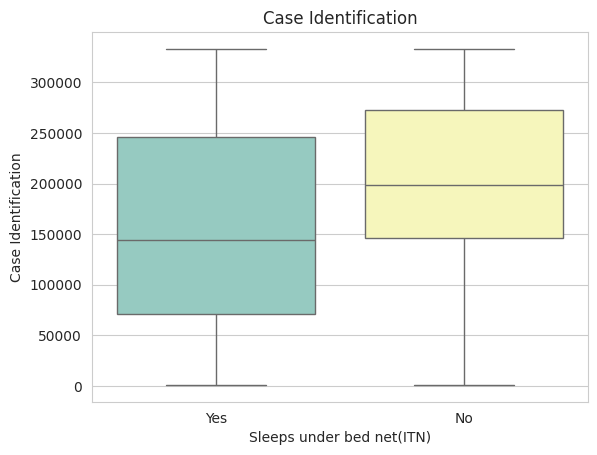

In [26]:
# visualizing the dataset on some categorical variables

def plot_box(malaria_data_gdf, cols, col_x = 'Sleeps under bed net(ITN)'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(x=col_x, y=col, data=malaria_data_gdf, palette="Set3")
        plt.title(col)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

num_cols = ['Case Identification']
plot_box(malaria_data_gdf, num_cols)

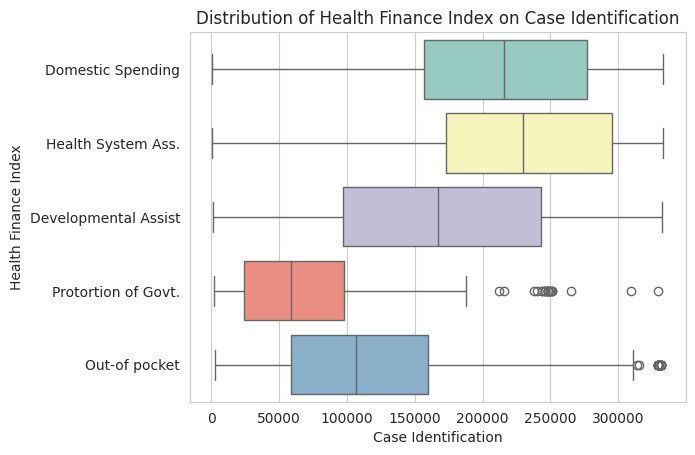

In [27]:
def plot_box(malaria_data_gdf, cols, col_x = 'Case Identification'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(x=col_x, y=col, data=malaria_data_gdf, palette='Set3')
        plt.title(f'Distribution of {col} on {col_x}')
        plt.xlabel(col_x)
        plt.ylabel(col)
        plt.show()

hel_col = 'Health Finance Index'
plot_box(malaria_data_gdf, [hel_col])

In [28]:
import mapclassify

malaria_data_gdf['malaria_class'] = mapclassify.Quantiles(malaria_data_gdf['Malaria_rate'], k=5).yb
print(malaria_data_gdf['malaria_class'].value_counts())

malaria_class
1    4810
0    2334
2     601
Name: count, dtype: int64


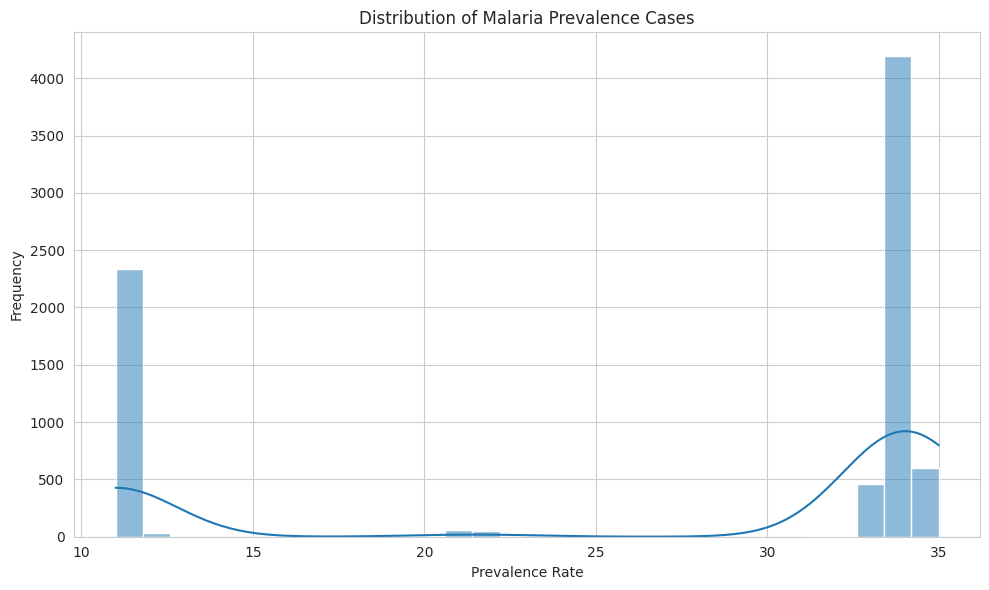

In [29]:
# Plot distribution and histogram chart of Malaria Prevalence

plt.figure(figsize=(10, 6))
sns.histplot(data=malaria_data_gdf, x='Malaria_rate', bins=30, kde=True)
plt.title('Distribution of Malaria Prevalence Cases')
plt.xlabel('Prevalence Rate')
plt.ylabel('Frequency')
plt.tight_layout()
#plt.savefig('malaria_distribution.png')
plt.show()

<Axes: >

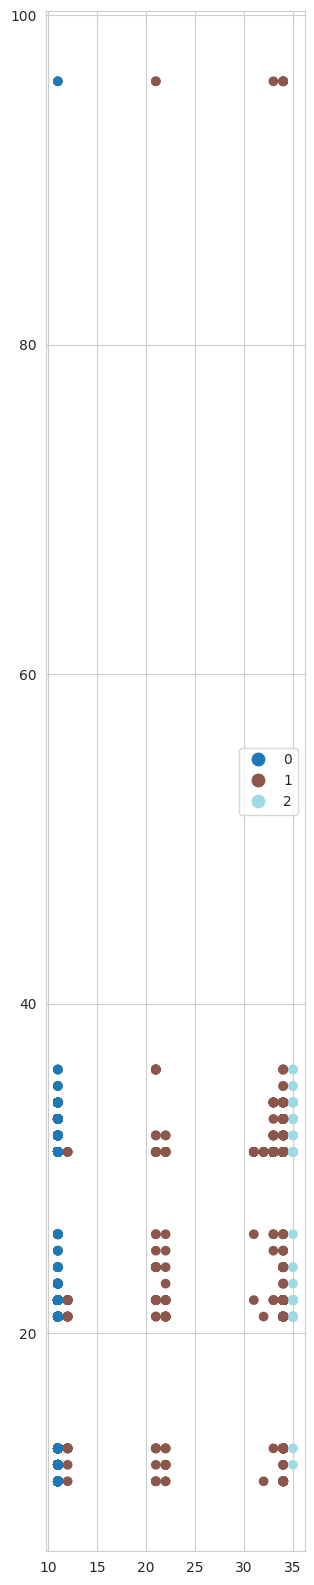

In [30]:
side_by_side = (4, 20)
malaria_data_gdf.plot(column='malaria_class', categorical=True, cmap='tab20', legend=True, figsize=(side_by_side))

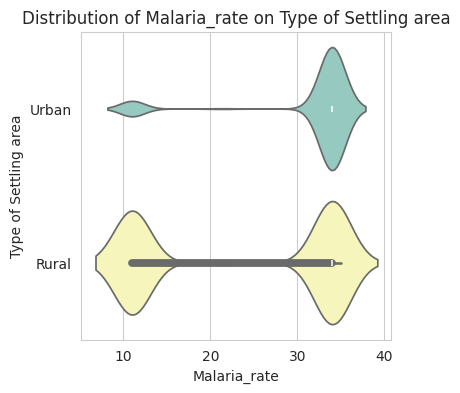

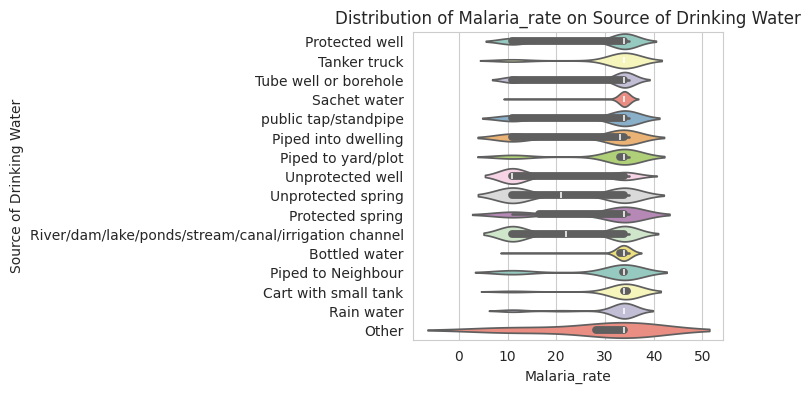

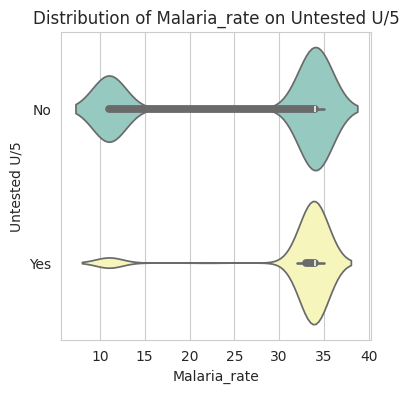

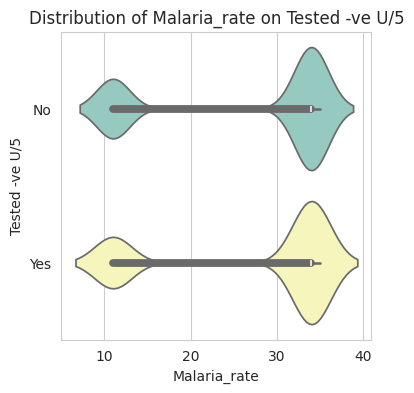

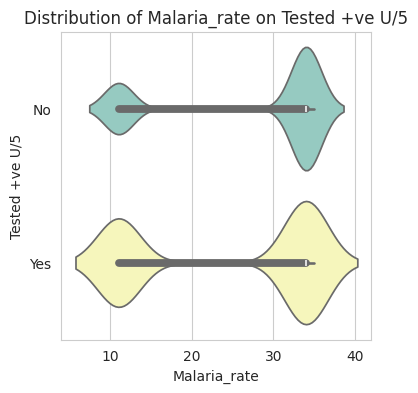

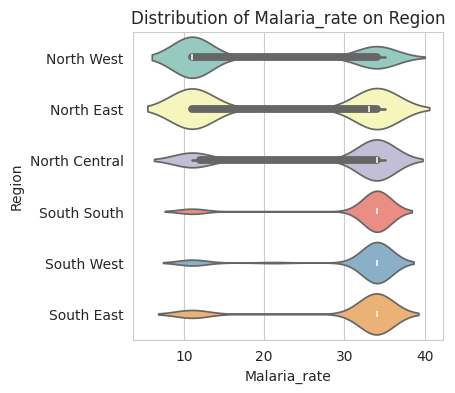

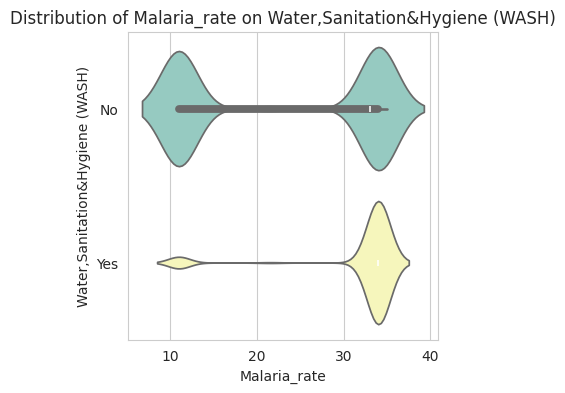

In [31]:
cat_cols = ['Type of Settling area', 'Source of Drinking Water', 'Untested U/5', 'Tested -ve U/5', 'Tested +ve U/5', 'Region', 'Water,Sanitation&Hygiene (WASH)']

def plot_violin(malaria_data_gdf, col, col_x='Malaria_rate'):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.violinplot(x=col_x, y=col, data=malaria_data_gdf, palette='Set3')
    plt.title(f'Distribution of {col_x} on {col}')
    plt.xlabel(col_x)
    plt.ylabel(col)
    plt.show()

for col in cat_cols:
    plot_violin(malaria_data_gdf, col)

### Population / Weather visualization

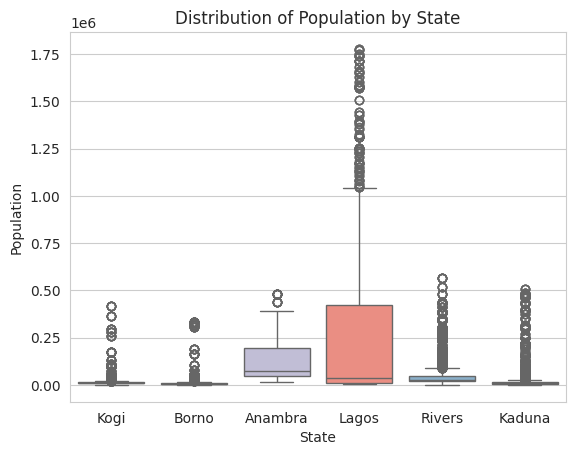

In [32]:
def plot_box(pop_weather_gdf, cols, col_x = 'State'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.boxplot(x=col_x, y=col, data=pop_weather_gdf, palette="Set3")
        plt.title(f'Distribution of {col} by {col_x}')
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)# Set text for y axis
        plt.show()

num_cols = ["Population"]
plot_box(pop_weather_gdf, num_cols, col_x='State')

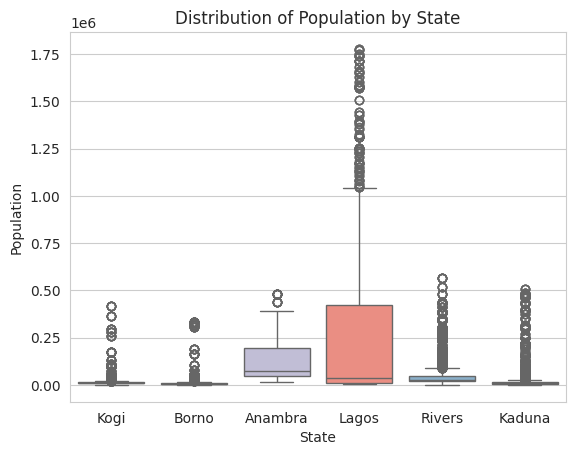

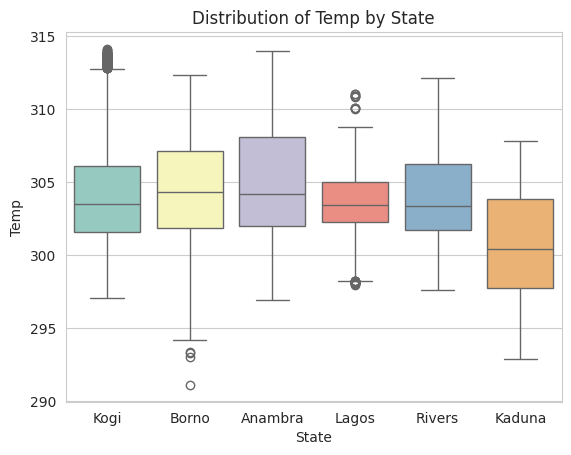

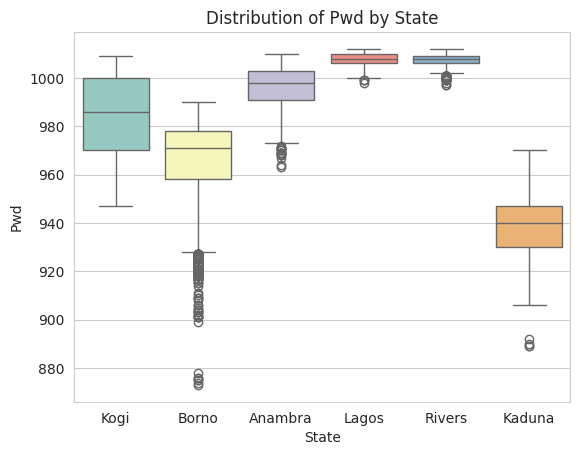

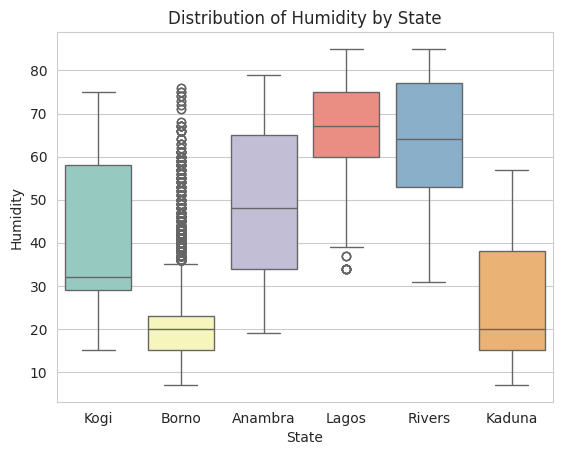


['Population', 'Temp', 'Pwd', 'Humidity']


In [33]:
pop_num_cols = ['Population', 'Temp', 'Pwd', 'Humidity']
plot_box(pop_weather_gdf, pop_num_cols)

print("")
print(pop_num_cols)

## Correlation matrix

###
Calculate and visualize the correlation matrix of the numerical variables to understand their linear relationships.


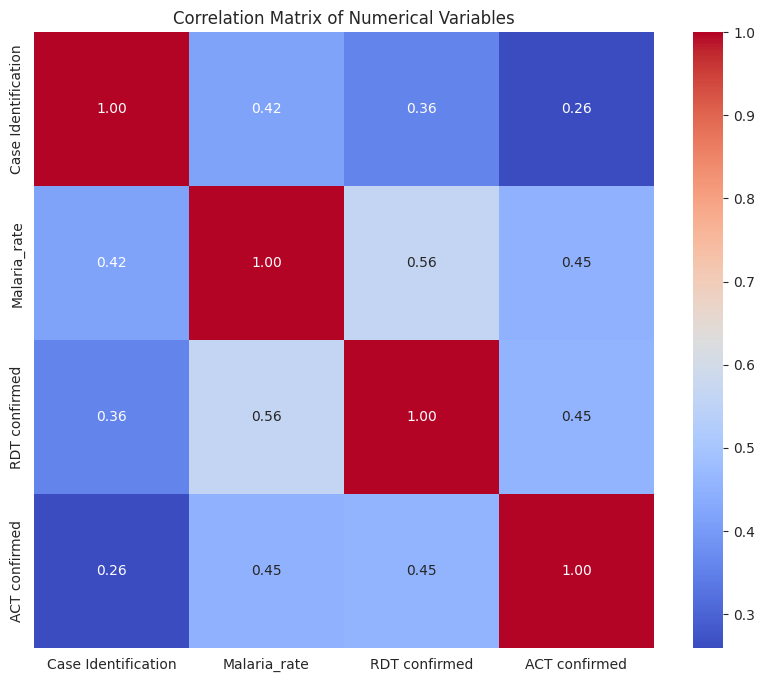

In [34]:
def plot_correlation_matrix(malaria_data_gdf, numerical_cols):
    correlation_matrix = malaria_data_gdf[numerical_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Variables')
    plt.show()
    return correlation_matrix

numerical_cols = ['Case Identification', 'Malaria_rate', 'RDT confirmed', 'ACT confirmed']
correlation_matrix = plot_correlation_matrix(malaria_data_gdf, numerical_cols)


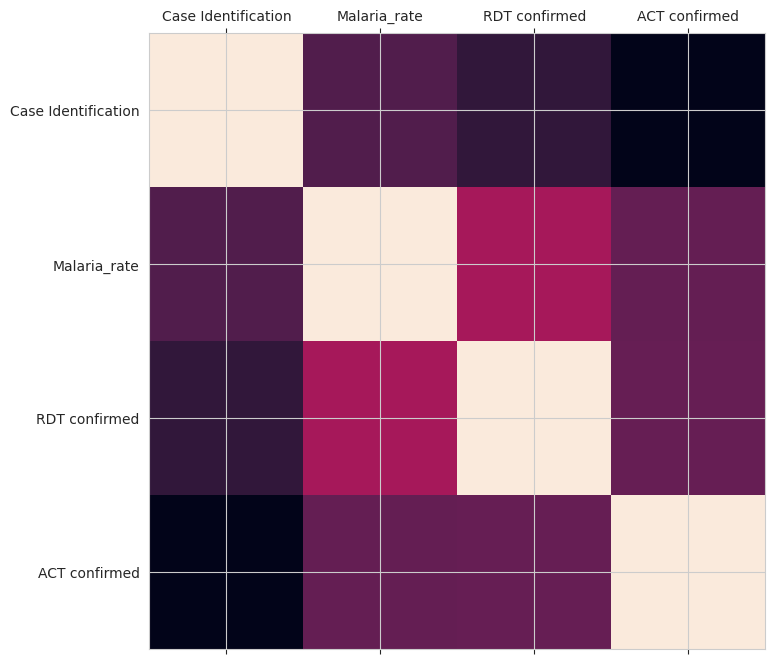

In [35]:
def plot_correlation_matrix(numerical_cols, pop_num_cols):
  correlation_matrix = malaria_data_gdf.corr(pop_weather_gdf)    # data frame correlation function


fig, ax = plt.subplots(figsize=(10, 8))
ax.matshow(correlation_matrix)   # color code the rectangles by correlation value
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)  # draw x tick marks
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns);  # draw y tick marks


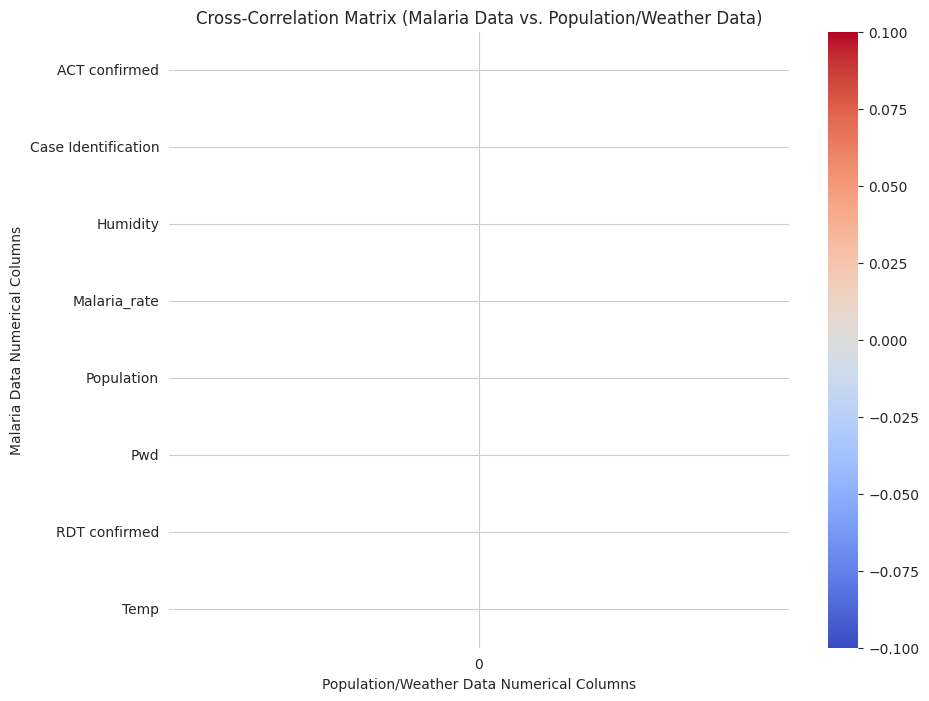

In [36]:
# Select the numerical columns from each GeoDataFrame
malaria_numerical = malaria_data_gdf[numerical_cols]
pop_weather_numerical = pop_weather_gdf[pop_num_cols]

cross_correlation_matrix = malaria_numerical.corrwith(pop_weather_numerical)

# Visualize the cross-correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cross_correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cross-Correlation Matrix (Malaria Data vs. Population/Weather Data)')
plt.xlabel("Population/Weather Data Numerical Columns")
plt.ylabel("Malaria Data Numerical Columns")
plt.show()

In [37]:
print(malaria_data_gdf.head())
print(pop_weather_gdf.head())

   Case Identification      Region Type of Settling area  \
0                 1002  North West                 Urban   
1                 1004  North West                 Urban   
2                 1007  North West                 Urban   
3                 1010  North West                 Urban   
4                 1013  North West                 Urban   

  Source of Drinking Water Housing Structure Air pollution  Malaria_rate  \
0           Protected well       Panel Walls           Yes            34   
1             Tanker truck       Panel Walls           Yes            22   
2    Tube well or borehole       Panel Walls           Yes            34   
3    Tube well or borehole       Panel Walls           Yes            34   
4             Tanker truck       Panel Walls           Yes            33   

   RDT confirmed  ACT confirmed Tested +ve U/5 Tested -ve U/5 Untested U/5  \
0             31             31             No             No           No   
1             31          

In [38]:
# Aggregate malaria_data_gdf by 'State' using counts and sums
malaria_agg_sum = malaria_data_gdf.groupby('State').agg(
    malaria_cases=('Case Identification', 'count'),
    total_rdt_confirmed=('RDT confirmed', 'sum'),
    total_act_confirmed=('ACT confirmed', 'sum'),
    total_malaria_prevalence=('Malaria_rate', 'sum') # sum of malaria prevalence values
).reset_index()

# Aggregate pop_weather_gdf by 'State' using sum
pop_weather_agg_sum = pop_weather_gdf.groupby('State').agg(
    total_population=('Population', 'sum'),
    total_temp=('Temp', 'sum'),
    total_humidity=('Humidity', 'sum'),
    total_sea_level=('Sea_Level', 'sum'),
    total_pwd=('Pwd', 'sum'),
    total_wind_degree=('Wind_degree', 'sum'),
    total_cloud=('Cloud desc.', 'sum')
).reset_index()

# Merge aggregated DataFrames
merged_agg_sum = pd.merge(malaria_agg_sum, pop_weather_agg_sum, on='State', how='left')

# Inspect results
display(merged_agg_sum.head())
merged_agg_sum.info()


State  malaria_cases  total_rdt_confirmed  total_act_confirmed  \
0       Abia            225                 6769                 6780   
1    Adamawa            225                 6406                 5343   
2  Akwa Ibom            220                 6004                 6325   
3    Anambra            168                 5185                 5210   
4     Bauchi            225                 5177                 5243   

   total_malaria_prevalence  total_population  total_temp  total_humidity  \
0                      6880               NaN         NaN             NaN   
1                      5277               NaN         NaN             NaN   
2                      6589               NaN         NaN             NaN   
3                      5558       253842145.0   624399.94         99964.0   
4                      4864               NaN         NaN             NaN   

   total_sea_level  total_pwd  total_wind_degree  total_cloud  
0              NaN        NaN                NaN          NaN  
1              NaN        NaN                NaN          NaN  
2              NaN        NaN                NaN          NaN  
3        2066671.0  2042006.0           404469.0     158431.0  
4              NaN        NaN                NaN          NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   State                     37 non-null     object 
 1   malaria_cases             37 non-null     int64  
 2   total_rdt_confirmed       37 non-null     int64  
 3   total_act_confirmed       37 non-null     int64  
 4   total_malaria_prevalence  37 non-null     int64  
 5   total_population          5 non-null      float64
 6   total_temp                5 non-null      float64
 7   total_humidity            5 non-null      float64
 8   total_sea_level           5 non-null      float64
 9   total_pwd                 5 non-null      float64
 10  total_wind_degree         5 non-null      float64
 11  total_cloud               5 non-null      float64
dtypes: float64(7), int64(4), object(1)
memory usage: 3.6+ KB


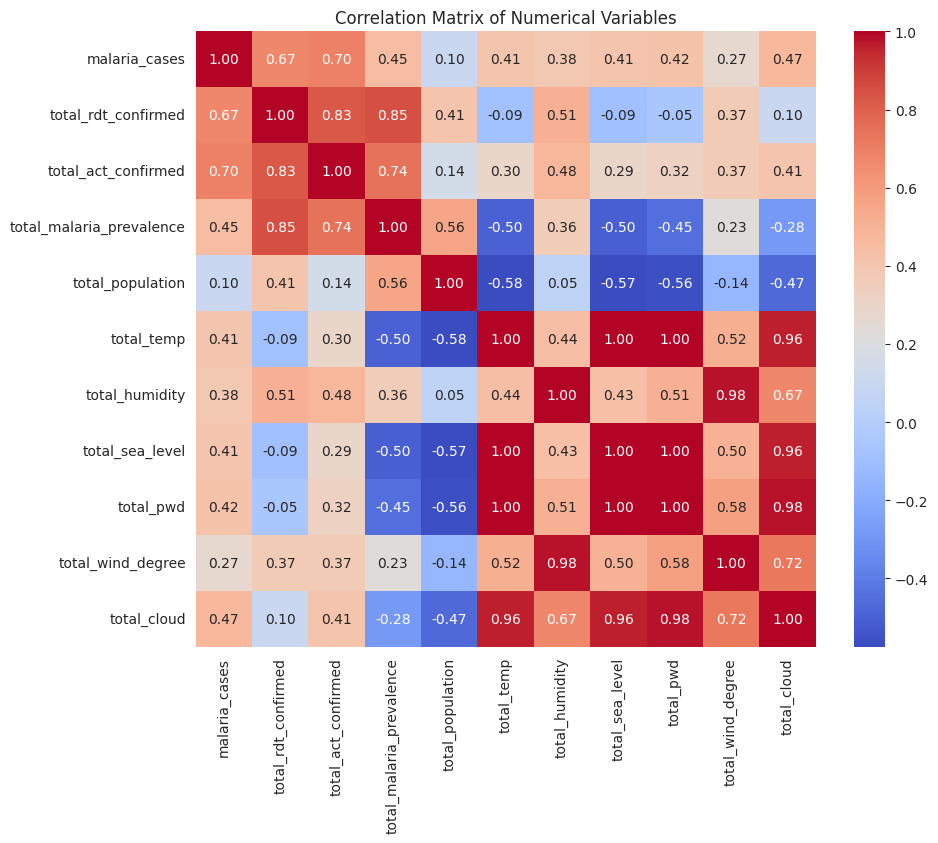

malaria_cases  total_rdt_confirmed  \
malaria_cases                  1.000000             0.668147   
total_rdt_confirmed            0.668147             1.000000   
total_act_confirmed            0.695270             0.825925   
total_malaria_prevalence       0.446031             0.847644   
total_population               0.100175             0.414748   
total_temp                     0.408618            -0.089183   
total_humidity                 0.384392             0.510491   
total_sea_level                0.410012            -0.094090   
total_pwd                      0.418870            -0.048121   
total_wind_degree              0.271533             0.367406   
total_cloud                    0.473289             0.100786   

                          total_act_confirmed  total_malaria_prevalence  \
malaria_cases                        0.695270                  0.446031   
total_rdt_confirmed                  0.825925                  0.847644   
total_act_confirmed                  1.000000                  0.744912   
total_malaria_prevalence             0.744912                  1.000000   
total_population                     0.144620                  0.559033   
total_temp                           0.295128                 -0.497251   
total_humidity                       0.482612                  0.363046   
total_sea_level                      0.293418                 -0.504176   
total_pwd                            0.318819                 -0.450542   
total_wind_degree                    0.367787                  0.228424   
total_cloud                          0.411145                 -0.284866   

                          total_population  total_temp  total_humidity  \
malaria_cases                     0.100175    0.408618        0.384392   
total_rdt_confirmed               0.414748   -0.089183        0.510491   
total_act_confirmed               0.144620    0.295128        0.482612   
total_malaria_prevalence          0.559033   -0.497251        0.363046   
total_population                  1.000000   -0.576646        0.049614   
total_temp                       -0.576646    1.000000        0.444809   
total_humidity                    0.049614    0.444809        1.000000   
total_sea_level                  -0.573459    0.999870        0.433458   
total_pwd                        -0.559930    0.997370        0.507594   
total_wind_degree                -0.143399    0.516727        0.976657   
total_cloud                      -0.466313    0.961286        0.673182   

                          total_sea_level  total_pwd  total_wind_degree  \
malaria_cases                    0.410012   0.418870           0.271533   
total_rdt_confirmed             -0.094090  -0.048121           0.367406   
total_act_confirmed              0.293418   0.318819           0.367787   
total_malaria_prevalence        -0.504176  -0.450542           0.228424   
total_population                -0.573459  -0.559930          -0.143399   
total_temp                       0.999870   0.997370           0.516727   
total_humidity                   0.433458   0.507594           0.976657   
total_sea_level                  1.000000   0.996215           0.504305   
total_pwd                        0.996215   1.000000           0.577143   
total_wind_degree                0.504305   0.577143           1.000000   
total_cloud                      0.957653   0.978418           0.724583   

                          total_cloud  
malaria_cases                0.473289  
total_rdt_confirmed          0.100786  
total_act_confirmed          0.411145  
total_malaria_prevalence    -0.284866  
total_population            -0.466313  
total_temp                   0.961286  
total_humidity               0.673182  
total_sea_level              0.957653  
total_pwd                    0.978418  
total_wind_degree            0.724583  
total_cloud                  1.000000

In [39]:
merge_numerical_cols = ['malaria_cases', 'total_rdt_confirmed', 'total_act_confirmed', 'total_malaria_prevalence',
                        'total_population', 'total_temp', 'total_humidity', 'total_sea_level',
                        'total_pwd', 'total_wind_degree', 'total_cloud']


correlation_matrix_merge = merged_agg_sum[merge_numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_merge, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

display(correlation_matrix_merge)

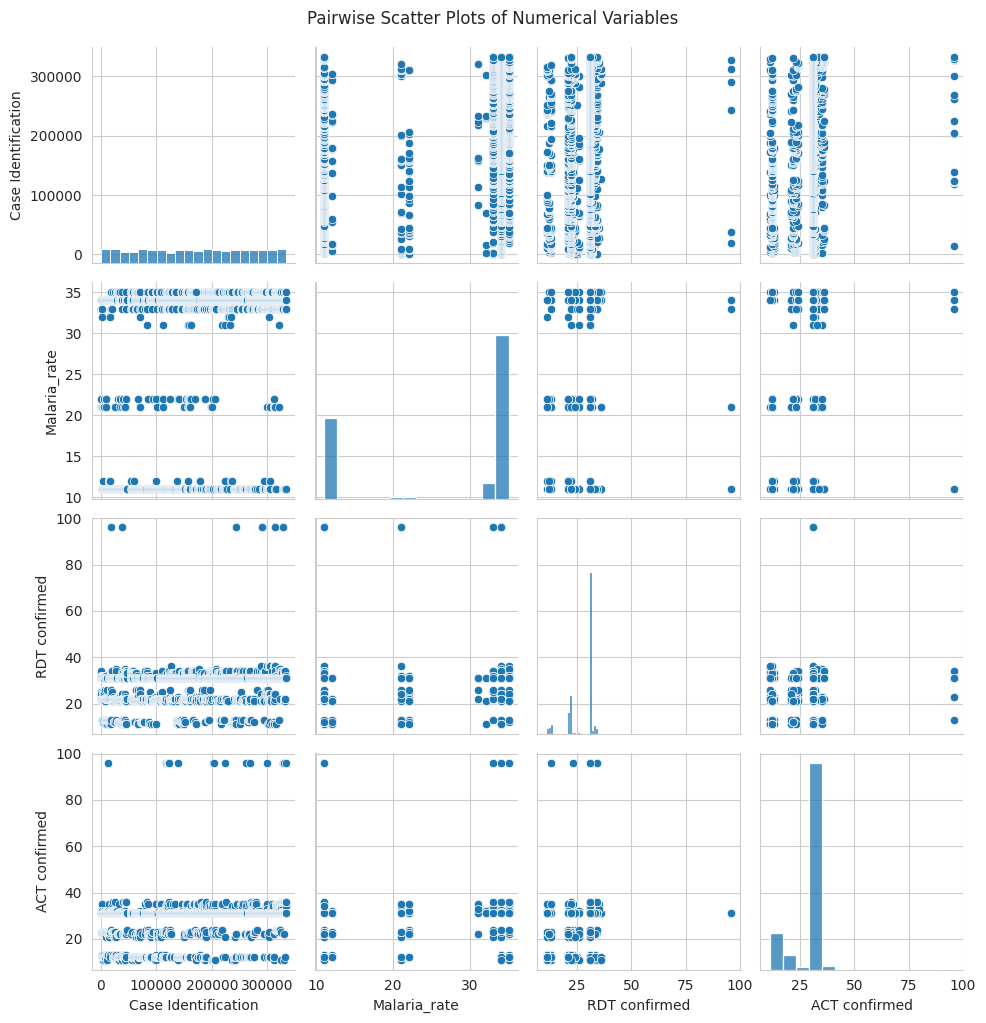

In [40]:
sns.pairplot(malaria_data_gdf[numerical_cols])
plt.suptitle('Pairwise Scatter Plots of Numerical Variables', y=1.02)
plt.show()

In [41]:
#load the shapefile
state_bound = gpd.read_file('/content/grid3_nga_boundary_vaccstates.shp')

# Drop unnecessary columns
state_bound.drop(['globalid', 'editor', 'source', 'timestamp'], axis=1, inplace=True)

# Rename the remaining columns
state_bound.columns=['Unique ID ', 'State', 'Statecode', 'CapCity', 'Geozone', 'geometry']

print(state_bound.shape)
state_bound

(37, 6)


Unique ID         State Statecode        CapCity Geozone  \
0         1187  Cross River        CR        Calabar     SSZ   
1         1175          Fct        FC          Abuja     NCZ   
2         1190         Ogun        OG       Abeokuta     SWZ   
3         1191          Oyo        OY        Ibandan     SWZ   
4         1177       Sokoto        SO         Sokoto     NWZ   
5         1178      Zamfara        ZA          Gusau     NWZ   
6         1179        Lagos        LA          Lagos     SWZ   
7         1193    Akwa Ibom        AK            Uyo     SSZ   
8         1194      Bayelsa        BY        Yenagoa     SSZ   
9         1195         Ondo        ON          Akure     SWZ   
10        1196        Delta        DE          Asaba     SSZ   
11        1197       Rivers        RI  Port Harcourt     SSZ   
12        1182        Kwara        KW         Ilorin     NCZ   
13        1183         Kogi        KO         Lokoja     NCZ   
14        1184        Benue        BE        Makurdi     NCZ   
15        1151        Borno        BR      Maiduguri     NEZ   
16        1160      Katsina        KT        Katsina     NWZ   
17        1161      Plateau        PL            Jos     NCZ   
18        1162          Edo        ED     Benin City     SSZ   
19        1163       Jigawa        JI          Dutse     NWZ   
20        1165      Anambra        AN           Awka     SEZ   
21        1166         Kano        KN           Kano     NWZ   
22        1167     Nasarawa        NA          Lafia     NCZ   
23        1168        Kebbi        KB   Birnin Kebbi     NWZ   
24        1169          Imo        IM         Owerri     SEZ   
25        1148        Gombe        GO          Gombe     NEZ   
26        1149      Adamawa        AD           Yola     NEZ   
27        1150         Yobe        YO       Damaturu     NEZ   
28        1174         Abia        AB        Umuahia     SEZ   
29        1153        Ekiti        EK            Ado     SWZ   
30        1156         Osun        OS        Oshogbo     SWZ   
31        1157       Bauchi        BA         Bauchi     NEZ   
32        1158        Niger        NI          Minna     NCZ   
33        1159       Kaduna        KD         Kaduna     NWZ   
34        1170        Enugu        EN          Enugu     SEZ   
35        1171       Taraba        TA        Jalingo     NEZ   
36        1173       Ebonyi        EB      Abakaliki     SEZ   

                                             geometry  
0   POLYGON ((8.46076 4.75455, 8.45885 4.75393, 8....  
1   POLYGON ((7.47762 8.63133, 7.44303 8.59328, 7....  
2   POLYGON ((4.59755 6.36057, 4.59757 6.35688, 4....  
3   POLYGON ((3.99896 7.12657, 3.99755 7.12617, 3....  
4   POLYGON ((4.63265 11.67143, 4.62886 11.6681, 4...  
5   POLYGON ((6.57204 11.02215, 6.57237 11.02276, ...  
6   POLYGON ((3.02077 6.39705, 3.00694 6.39661, 2....  
7   POLYGON ((7.54124 4.73247, 7.53394 4.75336, 7....  
8   POLYGON ((6.13651 4.27485, 6.11836 4.27218, 6....  
9   POLYGON ((5.03423 5.98874, 5.02017 5.95507, 5....  
10  POLYGON ((6.28354 5.2706, 6.28383 5.2665, 6.28...  
11  POLYGON ((6.85818 4.39824, 6.85018 4.39009, 6....  
12  POLYGON ((5.29907 8.00767, 5.29778 8.00767, 5....  
13  POLYGON ((6.71574 6.56035, 6.67203 6.56752, 6....  
14  POLYGON ((9.66416 6.93569, 9.6457 6.89482, 9.6...  
15  POLYGON ((11.98919 10.03755, 11.97055 10.03494...  
16  POLYGON ((7.14427 11.13012, 7.13381 11.13537, ...  
17  POLYGON ((9.85053 8.42207, 9.84106 8.41617, 9....  
18  POLYGON ((6.1005 5.80169, 6.09374 5.79412, 6.0...  
19  POLYGON ((9.85782 11.02319, 9.85687 11.0259, 9...  
20  POLYGON ((6.86365 5.74933, 6.86324 5.74965, 6....  
21  POLYGON ((7.80552 11.3717, 7.80512 11.37171, 7...  
22  POLYGON ((7.62491 8.02953, 7.58347 8.03769, 7....  
23  POLYGON ((5.39667 11.02606, 5.38899 11.03747, ...  
24  POLYGON ((7.38548 5.50336, 7.38477 5.50151, 7....  
25  POLYGON ((10.96913 9.61535, 10.96932 9.6155, 1...  
26  POLYGON ((12.20157 8.10679, 12.20152 8.10679, ...  
27 

In [42]:
state_bound = state_bound.to_crs(epsg=4326)

print(state_bound.crs)

EPSG:4326


### **Creating Folium map centered on Nigeria**
*   **Add interactive Tooltip to the chororpleth layer**
*   **Add cluster marker**


*   **Add HeatMap**
*   **Add Layer Control**

In [43]:
# Create a Folium map centered on Nigeria
m_choropleth = folium.Map(location=[9.0820, 8.6753], zoom_start=6, tiles="CartoDB positron")

# Merge the aggregated malaria data with the state boundaries GeoDataFrame
merged_state_data = state_bound.merge(merged_agg_sum, on='State', how='left')

# For Choropleth (Hotspot Map) using the merged GeoDataFrame
choropleth_layer = folium.Choropleth(
    geo_data=merged_state_data,  # Use the merged GeoDataFrame
    name='Malaria Prevalence Hotspots',
    data=merged_state_data,
    columns=['State', 'total_malaria_prevalence' ],
    key_on='feature.properties.State', # Key to join with the geo_data properties
    fill_color='Reds',
    fill_opacity=0.6,
    line_opacity=0.4,
    legend_name='Total Malaria Prevalence (Hotspots)'
).add_to(m_choropleth)

# Adding interactive tooltips to the Choropleth layer, that gives access the geojson attribute of the choropleth layer
folium.features.GeoJsonTooltip(
    fields=['State', 'total_malaria_prevalence', 'malaria_cases', 'total_population', 'total_temp', 'total_humidity'],
    aliases=['State:', 'Total Malaria Prevalence:', 'Cases:', 'Population:', 'Temperature:', 'Humidity:'],
    localize=True,
    sticky=True
).add_to(choropleth_layer.geojson)


folium.LayerControl().add_to(m_choropleth)

display(m_choropleth)

In [44]:
import folium
from folium.plugins import MarkerCluster, HeatMap


m_choropleth = folium.Map(location=[9.0829, 8.6753], zoom_start=6, tiles="CartoDB positron")

merged_state_data = state_bound.merge(merged_agg_sum, on='State', how='left')

choropleth_layer = folium.Choropleth( # Changed to Choropleth class
    geo_data=merged_state_data, # Changed nig_data to geo_data
    name='Malaria Prevalence Hotspots',
    data=merged_state_data,
    columns=['State', 'total_malaria_prevalence'],
    key_on='feature.properties.State',
    fill_color='Reds',
    fill_opacity=0.6,
    line_opacity=0.4,
    legend_name='Malaria Prevalence (Hotspots)' # Changed legend to legend_name
).add_to(m_choropleth)

folium.features.GeoJsonTooltip(
    fields=['State', 'total_malaria_prevalence', 'malaria_cases', 'total_population', 'total_temp', 'total_humidity'],
    aliases=['State:', 'Total Malaria Prevalence:', 'Cases:', 'Population:', 'Temperature:', 'Humidity:'],
    localize=True,
    sticky=True
).add_to(choropleth_layer.geojson)


marker_cluster = MarkerCluster(name='Malaria Cases Cluster').add_to(m_choropleth)

# one marker per state @ approx. centriod

for idx, row in merged_state_data.iterrows():
  if pd.notnull(row['total_malaria_prevalence']):
    centriod = row.geometry.centroid # Changed centriod to centroid
    lat, lon = centriod.y, centriod.x

    folium.CircleMarker(
        location=[lat, lon],
        radius=max(5, row['malaria_cases'] / 1000),
        color='blue',
        fill=True,
        fill_opacity=0.4,
        popup=folium.Popup(
            f"<b>State:</b> {row['State']}<br>"
            f"<b>Total Prevalence:</b> {row['total_malaria_prevalence']}<br>"
            f"<b>Reported Cases:</b> {row['malaria_cases']}<br>"
            f"<b>Population:</b> {row['total_population']}<br>"
        )
    ).add_to(marker_cluster)


heatmap_data = []

for idx, row in merged_state_data.iterrows():
  if pd.notnull(row['total_malaria_prevalence']) and row.geometry is not None:
    centriod = row.geometry.centroid # Changed centriod to centroid
    lat, lon = centriod.y, centriod.x
    heatmap_data.append([lat, lon, row['malaria_cases']])


HeatMap(
    heatmap_data,
    name='Malaria Heatmap',
    radius=20,
    blur=15,
    max_zoom=8
).add_to(m_choropleth)


# add layer control
folium.LayerControl().add_to(m_choropleth)

display(m_choropleth)

# **Model Training**

In [45]:
malaria_ill = pd.read_csv('/content/Numeric Malaria Data.csv')
malaria_ill

print(malaria_ill.info())
print(malaria_ill.describe())
print(malaria_ill.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hhid     7745 non-null   int64  
 1   hv024    7745 non-null   int64  
 2   hv025    7745 non-null   int64  
 3   hv201    7745 non-null   int64  
 4   hv205    7744 non-null   float64
 5   hv206    7745 non-null   int64  
 6   hv213    7745 non-null   int64  
 7   hv214    7745 non-null   int64  
 8   hv215    7745 non-null   int64  
 9   hv210    7745 non-null   int64  
 10  hv211    7745 non-null   int64  
 11  hv212    7745 non-null   int64  
 12  hv227    7745 non-null   int64  
 13  hv244    7745 non-null   int64  
 14  hv247    7745 non-null   int64  
 15  hv270    7745 non-null   int64  
 16  sh16_22  3 non-null      float64
 17  shstate  7745 non-null   int64  
dtypes: float64(2), int64(16)
memory usage: 1.1 MB
None
                hhid        hv024       hv025        hv201        hv205  \
co

In [46]:
malaria_ill = pd.DataFrame(malaria_ill)
malaria_ill.columns=['Case Identification', 'Region', 'Type of Settling area', 'Source of Drinking Water', 'Housing Structure',
                'Air pollution', 'Malaria_rate', 'RDT confirmed', 'ACT confirmed', 'Tested +ve U/5', 'Tested -ve U/5',
                'Untested U/5', 'Sleeps under bed net(ITN)', 'Untested O/5', 'Water,Sanitation&Hygiene (WASH)',
                'Health Finance Index', 'Untested priv', 'State']
print(malaria_ill.shape)
malaria_ill.head()

(7745, 18)


Case Identification  Region  Type of Settling area  \
0                 1002       3                      1   
1                 1004       3                      1   
2                 1007       3                      1   
3                 1010       3                      1   
4                 1013       3                      1   

   Source of Drinking Water  Housing Structure  Air pollution  Malaria_rate  \
0                        31               21.0              1            34   
1                        61               21.0              1            22   
2                        21               21.0              1            34   
3                        21               21.0              1            34   
4                        61               21.0              1            33   

   RDT confirmed  ACT confirmed  Tested +ve U/5  Tested -ve U/5  Untested U/5  \
0             31             31               0               0             0   
1             31             31               1               0             1   
2             31             31               0               1             0   
3             31             31               1               1             1   
4             31             31               0               1             1   

   Sleeps under bed net(ITN)  Untested O/5  Water,Sanitation&Hygiene (WASH)  \
0                          1             1                                0   
1                          1             1                                1   
2                          1             0                                0   
3                          1             0                                0   
4                          1             0                                1   

   Health Finance Index  Untested priv  State  
0                     4            NaN     10  
1                     4            NaN     10  
2                     4            NaN     10  
3                     5            NaN     10  
4                     5            NaN     10

In [47]:
malaria_ill['Housing Structure'].fillna(
    round(malaria_ill['Housing Structure'].mode()[0], 2),
    inplace=True
)

malaria_ill['Housing Structure'] = malaria_ill['Housing Structure'].astype(int)
malaria_ill

Case Identification  Region  Type of Settling area  \
0                    1002       3                      1   
1                    1004       3                      1   
2                    1007       3                      1   
3                    1010       3                      1   
4                    1013       3                      1   
...                   ...     ...                    ...   
7740               333108       6                      2   
7741               333113       6                      2   
7742               333119       6                      2   
7743               333124       6                      2   
7744               333129       6                      2   

      Source of Drinking Water  Housing Structure  Air pollution  \
0                           31                 21              1   
1                           61                 21              1   
2                           21                 21              1   
3                           21                 21              1   
4                           61                 21              1   
...                        ...                ...            ...   
7740                        21                 12              1   
7741                        72                 12              1   
7742                        72                 11              1   
7743                        21                 11              1   
7744                        72                 11              1   

      Malaria_rate  RDT confirmed  ACT confirmed  Tested +ve U/5  \
0               34             31             31               0   
1               22             31             31               1   
2               34             31             31               0   
3               34             31             31               1   
4               33             31             31               0   
...            ...            ...            ...             ...   
7740            34             31             36               0   
7741            34             31             36               0   
7742            33             31             36               0   
7743            34             31             36               0   
7744            35             31             36               0   

      Tested -ve U/5  Untested U/5  Sleeps under bed net(ITN)  Untested O/5  \
0                  0             0                          1             1   
1                  0             1                          1             1   
2                  1             0                          1             0   
3                  1             1                          1             0   
4                  1             1                          1             0   
...              ...           ...                        ...           ...   
7740               0             0                          1             0   
7741               0             0                          1             0   
7742               0             0                          0             0   
7743               1             0                          1             1   
7744               0             1                          1             0   

      Water,Sanitation&Hygiene (WASH)  Health Finance Index  Untested priv  \
0                                   0                     4            NaN   
1                                   1                     4            NaN   
2                                   0                     4            NaN   
3                                   0                     5            NaN   
4                                   1                     5            NaN   
...                               ...                   ...            ...   
7740                                1                     5            NaN   
7741                                1                     5            NaN   


In [48]:
malaria_ill['Housing Structure'].unique()

array([21, 22, 13, 11, 23, 31, 15, 41, 96, 42, 12, 14, 43])

In [49]:
malaria_ill.isnull().sum()

Case Identification                   0
Region                                0
Type of Settling area                 0
Source of Drinking Water              0
Housing Structure                     0
Air pollution                         0
Malaria_rate                          0
RDT confirmed                         0
ACT confirmed                         0
Tested +ve U/5                        0
Tested -ve U/5                        0
Untested U/5                          0
Sleeps under bed net(ITN)             0
Untested O/5                          0
Water,Sanitation&Hygiene (WASH)       0
Health Finance Index                  0
Untested priv                      7742
State                                 0
dtype: int64

In [50]:
malaria_ill.drop('Untested priv', axis=1, inplace=True)
malaria_ill.head()

Case Identification  Region  Type of Settling area  \
0                 1002       3                      1   
1                 1004       3                      1   
2                 1007       3                      1   
3                 1010       3                      1   
4                 1013       3                      1   

   Source of Drinking Water  Housing Structure  Air pollution  Malaria_rate  \
0                        31                 21              1            34   
1                        61                 21              1            22   
2                        21                 21              1            34   
3                        21                 21              1            34   
4                        61                 21              1            33   

   RDT confirmed  ACT confirmed  Tested +ve U/5  Tested -ve U/5  Untested U/5  \
0             31             31               0               0             0   
1             31             31               1               0             1   
2             31             31               0               1             0   
3             31             31               1               1             1   
4             31             31               0               1             1   

   Sleeps under bed net(ITN)  Untested O/5  Water,Sanitation&Hygiene (WASH)  \
0                          1             1                                0   
1                          1             1                                1   
2                          1             0                                0   
3                          1             0                                0   
4                          1             0                                1   

   Health Finance Index  State  
0                     4     10  
1                     4     10  
2                     4     10  
3                     5     10  
4                     5     10

Case Identification    Region  \
Case Identification                         1.000000  0.638409   
Region                                      0.638409  1.000000   
Type of Settling area                      -0.177266 -0.216489   
Source of Drinking Water                    0.242676  0.114729   
Housing Structure                          -0.117619 -0.117391   
Air pollution                               0.346377  0.289712   
Malaria_rate                                0.418109  0.249819   
RDT confirmed                               0.357156  0.204138   
ACT confirmed                               0.258999  0.195965   
Tested +ve U/5                             -0.146223 -0.126653   
Tested -ve U/5                             -0.065743 -0.079921   
Untested U/5                                0.069666  0.050046   
Sleeps under bed net(ITN)                  -0.209099 -0.076920   
Untested O/5                               -0.287561 -0.239670   
Water,Sanitation&Hygiene (WASH)             0.308290  0.202319   
Health Finance Index                        0.539692  0.362222   
State                                       0.999640  0.638659   

                                 Type of Settling area  \
Case Identification                          -0.177266   
Region                                       -0.216489   
Type of Settling area                         1.000000   
Source of Drinking Water                     -0.062668   
Housing Structure                             0.350128   
Air pollution                                -0.451181   
Malaria_rate                                 -0.369315   
RDT confirmed                                -0.343694   
ACT confirmed                                -0.290769   
Tested +ve U/5                                0.105237   
Tested -ve U/5                                0.059444   
Untested U/5                                 -0.207979   
Sleeps under bed net(ITN)                     0.081198   
Untested O/5                                  0.406885   
Water,Sanitation&Hygiene (WASH)              -0.362743   
Health Finance Index                         -0.552373   
State                                        -0.195641   

                                 Source of Drinking Water  Housing Structure  \
Case Identification                              0.242676          -0.117619   
Region                                           0.114729          -0.117391   
Type of Settling area                           -0.062668           0.350128   
Source of Drinking Water                         1.000000          -0.058206   
Housing Structure                               -0.058206           1.000000   
Air pollution                                    0.083321          -0.424193   
Malaria_rate                                     0.114668          -0.305976   
RDT confirmed                                    0.094403          -0.268062   
ACT confirmed                                    0.032614          -0.247530   
Tested +ve U/5                                  -0.056048           0.031716   
Tested -ve U/5                                  -0.046185           0.024172   
Untested U/5                                     0.076336          -0.260768   
Sleeps under bed net(ITN)                       -0.082932           0.044020   
Untested O/5                                    -0.119719           0.302066   
Water,Sanitation&Hygiene (WASH)                  0.133601          -0.375132   
Health Finance Index                             0.194949          -0.497206   
State                                            0.243476          -0.123879   

                                 Air pollution  Malaria_rate  RDT confirmed  \
Case Identification                   0.346377      0.418109       0.357156   
Region                                0.289712      0.249819       0.204138   
Type of Settling area                -0.451181     -0.369315      -0.343694   
Source of Drinking Water              0.08

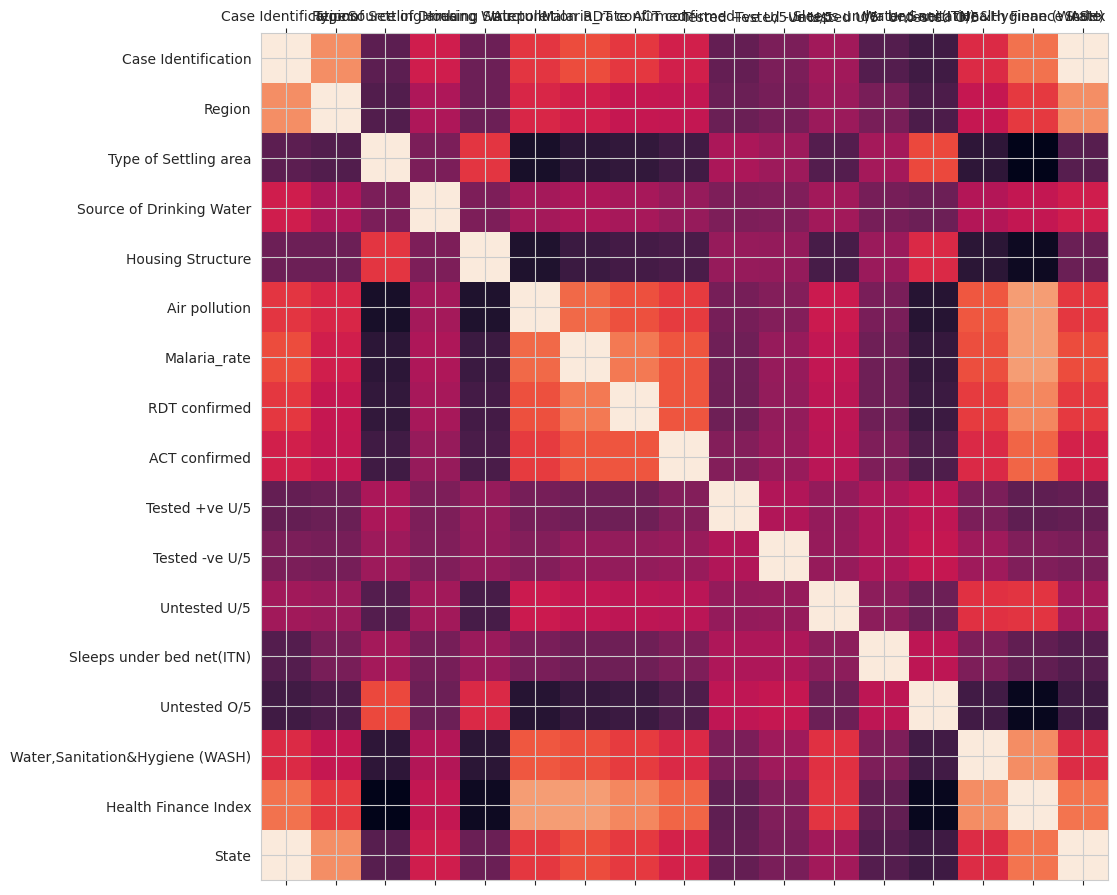

In [51]:
def plot_corr(malaria_ill, size=11):

  corr = malaria_ill.corr()
  fig, ax = plt.subplots(figsize=(size, size))
  ax.matshow(corr)
  plt.xticks(range(len(corr.columns)), corr.columns)
  plt.yticks(range(len(corr.columns)), corr.columns)


plot_corr(malaria_ill)
display(malaria_ill.corr())

In [52]:
del malaria_ill ['State']
malaria_ill.head()

Case Identification  Region  Type of Settling area  \
0                 1002       3                      1   
1                 1004       3                      1   
2                 1007       3                      1   
3                 1010       3                      1   
4                 1013       3                      1   

   Source of Drinking Water  Housing Structure  Air pollution  Malaria_rate  \
0                        31                 21              1            34   
1                        61                 21              1            22   
2                        21                 21              1            34   
3                        21                 21              1            34   
4                        61                 21              1            33   

   RDT confirmed  ACT confirmed  Tested +ve U/5  Tested -ve U/5  Untested U/5  \
0             31             31               0               0             0   
1             31             31               1               0             1   
2             31             31               0               1             0   
3             31             31               1               1             1   
4             31             31               0               1             1   

   Sleeps under bed net(ITN)  Untested O/5  Water,Sanitation&Hygiene (WASH)  \
0                          1             1                                0   
1                          1             1                                1   
2                          1             0                                0   
3                          1             0                                0   
4                          1             0                                1   

   Health Finance Index  
0                     4  
1                     4  
2                     4  
3                     5  
4                     5

In [53]:
malaria_ill['Malaria_rate'].unique()

array([34, 22, 33, 21, 11, 32, 12, 35, 31])

In [54]:
num_case = len(malaria_ill)
num_true = len(malaria_ill.loc[malaria_ill['Sleeps under bed net(ITN)'] == 1])
num_false = len(malaria_ill.loc[malaria_ill['Sleeps under bed net(ITN)'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_case) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_case) * 100))

Number of True cases:  5432 (70.14%)
Number of False cases: 2313 (29.86%)


### Data Split

In [55]:
#using sklearn.cross_validation import train_test_split

feature_col_names = ['Region', 'Type of Settling area', 'Source of Drinking Water', 'Housing Structure', 'Air pollution', 'Malaria_rate', 'RDT confirmed', 'ACT confirmed', 'Tested +ve U/5', 'Tested -ve U/5', 'Untested U/5', 'Untested O/5', 'Water,Sanitation&Hygiene (WASH)', 'Health Finance Index']
predicted_class_names = ['Sleeps under bed net(ITN)']

X = malaria_ill[feature_col_names].values     # predictor feature columns (8 X m)
y = malaria_ill[predicted_class_names].values # predicted class (1=true, 0=false) column (1 X m)
split_test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42)
                            # test_size = 0.2 is 20%, 42 is the answer to everything

In [56]:
x_train = pd.DataFrame(X_train, columns=feature_col_names)
x_test = pd.DataFrame(X_test, columns=feature_col_names)

In [57]:
print(x_train.shape)
print(x_test.shape)

(6196, 14)
(1549, 14)


In [58]:
print("{0:0.2f}% in training set".format((len(X_train)/len(malaria_ill.index)) * 100))
print("{0:0.2f}% in test set".format((len(X_test)/len(malaria_ill.index)) * 100))

80.00% in training set
20.00% in test set


In [59]:
print("Original True  : {0} ({1:0.2f}%)".format(len(malaria_ill.loc[malaria_ill['Sleeps under bed net(ITN)'] == 1]), (len(malaria_ill.loc[malaria_ill['Sleeps under bed net(ITN)'] == 1])/len(malaria_ill.index)) * 100.0))
print("Original False : {0} ({1:0.2f}%)".format(len(malaria_ill.loc[malaria_ill['Sleeps under bed net(ITN)'] == 0]), (len(malaria_ill.loc[malaria_ill['Sleeps under bed net(ITN)'] == 0])/len(malaria_ill.index)) * 100.0))
print("")
print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
print("")
print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

Original True  : 5432 (70.14%)
Original False : 2313 (29.86%)

Training True  : 4347 (70.16%)
Training False : 1849 (29.84%)

Test True      : 1085 (70.05%)
Test False     : 464 (29.95%)


## Using Naive Bayes ML Model Training

In [60]:
# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB()


* The Naive Bayes model has been trained.
* Below evaluate its performance on the training data to get an initial understanding of how well it learned the patterns.

In [61]:
# predict values using the training data
nb_predict_train = nb_model.predict(X_train)

# Accuracy
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_train, nb_predict_train) * 100))
print()

Accuracy: 63.33%



### Checking Performance on our Testing Data

In [62]:
nb_predict_test = nb_model.predict(X_test)

# training metrics
print("nb_predict_test", nb_predict_test)
print ("y_test", y_test)
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, nb_predict_test) * 100))

nb_predict_test [1 0 1 ... 1 0 0]
y_test [[1]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]
Accuracy: 62.43%


### Confusion Matrix:

The confusion matrix is a tabular output that summarizes the performance of a classification model. It shows the counts of:
(TN), (FP), (FN), (TP).

In [63]:
print("Confusion Matrix")
print("{0}".format(metrics.confusion_matrix(y_test, nb_predict_test)))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, nb_predict_test))

Confusion Matrix
[[214 250]
 [332 753]]

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.46      0.42       464
           1       0.75      0.69      0.72      1085

    accuracy                           0.62      1549
   macro avg       0.57      0.58      0.57      1549
weighted avg       0.64      0.62      0.63      1549



Classification Report: Precision, Recall, F1-score, support, Accuracy metrics.
The classification report provides key metrics for each class (0 and 1 in this case):
*   True Negatives (TN): 214 (The model correctly predicted 214 cases as False)
*   False Positives (FP): 250 (The model incorrectly predicted 250 cases as True, when they were actually False)
*   False Negatives (FN): 332 (The model incorrectly predicted 332 cases as False, when they were actually True)
*   True Positives (TP): 753 (The model correctly predicted 753 cases as True)


*   Precision: The ability of the classifier not to label as positive a sample that is negative. For class 0, when the model predicted 0, it was correct 39% of the time. For class 1, when the model predicted 1, it was correct 75% of the time.
*   Recall: The ability of the classifier to find all the positive samples. For class 0, of all the actual 0 cases, the model correctly identified 46% of them. For class 1, of all the actual 1 cases, the model correctly identified 69% of them.
*   F1-score: The harmonic mean of precision and recall. It's a good measure of a model's accuracy on a dataset. The F1-score is higher for class 1 (0.72) than for class 0 (0.42), indicating better performance in predicting class 1.
*   Support: The number of actual occurrences of the class in the specified dataset. There are 464 instances of class 0 and 1085 instances of class 1 in the test set.


*   **Accuracy**: The proportion of correct predictions out of the total number of predictions. In this case, it's 0.62 (or 62%), meaning the model correctly predicted the class for 62% of the test instances.

In summary, the model has a decent overall accuracy, but its performance is better at predicting class 1 (Sleeps under bed net(ITN) equal 1) than class 0 (Sleeps under bed net(ITN) equal 0), as indicated by the precision, recall, and F1-score for each class. The confusion matrix provides the raw counts behind these metrics.

# Random Forest Classification

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=10)      # Create random forest object
rf_model.fit(X_train, y_train.ravel())

print(rf_model)

RandomForestClassifier(n_estimators=10, random_state=42)


In [65]:
rf_predict_train = rf_model.predict(X_train)
# training metrics
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_train, rf_predict_train) * 100))

Accuracy: 92.83%


#### A far more better Accuracy level with Random Forest

### Test Data Prediction

In [66]:
rf_predict_test = rf_model.predict(X_test)
# training metrics
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, rf_predict_test) * 100))

Accuracy: 67.79%


In [67]:
print(metrics.confusion_matrix(y_test, rf_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, rf_predict_test))

[[165 299]
 [200 885]]

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.36      0.40       464
           1       0.75      0.82      0.78      1085

    accuracy                           0.68      1549
   macro avg       0.60      0.59      0.59      1549
weighted avg       0.66      0.68      0.67      1549



##### This output shows the performance of our Random Forest model on the test data. The accuracy is about 68%. The confusion matrix indicates that the model is better at correctly identifying cases that Sleeps under bed net(ITN) equal 1 to be (885 True Positives) compared to cases where Sleeps under bed net(ITN) equal 0 being (165 True Negatives). The classification report further supports in showing higher precision, recall, and f1-score for class 1.

# Using Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

lr_model =LogisticRegression(C=0.7, random_state=42, solver='liblinear', max_iter=10000)
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, lr_predict_test) * 100))
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))

Accuracy: 70.30%
[[  26  438]
 [  22 1063]]

Classification Report
              precision    recall  f1-score   support

           0       0.54      0.06      0.10       464
           1       0.71      0.98      0.82      1085

    accuracy                           0.70      1549
   macro avg       0.62      0.52      0.46      1549
weighted avg       0.66      0.70      0.61      1549



### This output is from the Logistic Regression model's evaluation.

Accuracy: The model achieved an accuracy of 0.7030, meaning it correctly predicted the outcome for approximately 70.3% of the instances in the test set.
Confusion Matrix: Actually shape the struggle and best performance within the prediction log for classes
(0 and 1).

In summary, the Logistic Regression model has a relatively high overall accuracy, but it is much better at predicting class 1 (Sleeps under bed net (ITN) equal 1) than class 0 (Sleeps under bed net (ITN) equal 0), as evidenced by the very low recall and F1-score for class 0. The confusion matrix clearly shows that the model is misclassifying a large number of class 0 instances as class 1 which again might be dependent on the imbalance of our dataset.

In [69]:
from joblib import dump
dump(lr_model, "Malaria LR Model")

['Malaria LR Model']

In [70]:
import joblib
lr_model = joblib.load("Malaria LR Model")

In [71]:
# Create a dictionary to map malaria rates to unique names based on their counts
# index of the sorted counts is use as a simple way to assign unique categories

malaria_rate_counts = malaria_ill['Malaria_rate'].value_counts()
malaria_rate_mapping = {serverity: f'Serverity_{i+1}' for i, (serverity, count) in enumerate(malaria_rate_counts.sort_values(ascending=False).items())}

print("Malaria Rate Mapping:")
print(malaria_rate_mapping)

# Apply the mapping to the 'Malaria_rate' column
malaria_ill['Malaria_rate_category'] = malaria_ill['Malaria_rate'].map(malaria_rate_mapping)

# Display the distribution of the new categorical column
print("\nDistribution of Malaria Rate Categories:")
print(malaria_ill['Malaria_rate_category'].value_counts())

# Display the first few rows with the new column
display(malaria_ill.head())

Malaria Rate Mapping:
{34: 'Serverity_1', 11: 'Serverity_2', 35: 'Serverity_3', 33: 'Serverity_4', 21: 'Serverity_5', 22: 'Serverity_6', 12: 'Serverity_7', 31: 'Serverity_8', 32: 'Serverity_9'}

Distribution of Malaria Rate Categories:
Malaria_rate_category
Serverity_1    4191
Serverity_2    2334
Serverity_3     601
Serverity_4     457
Serverity_5      58
Serverity_6      50
Serverity_7      36
Serverity_8      10
Serverity_9       8
Name: count, dtype: int64


Case Identification  Region  Type of Settling area  \
0                 1002       3                      1   
1                 1004       3                      1   
2                 1007       3                      1   
3                 1010       3                      1   
4                 1013       3                      1   

   Source of Drinking Water  Housing Structure  Air pollution  Malaria_rate  \
0                        31                 21              1            34   
1                        61                 21              1            22   
2                        21                 21              1            34   
3                        21                 21              1            34   
4                        61                 21              1            33   

   RDT confirmed  ACT confirmed  Tested +ve U/5  Tested -ve U/5  Untested U/5  \
0             31             31               0               0             0   
1             31             31               1               0             1   
2             31             31               0               1             0   
3             31             31               1               1             1   
4             31             31               0               1             1   

   Sleeps under bed net(ITN)  Untested O/5  Water,Sanitation&Hygiene (WASH)  \
0                          1             1                                0   
1                          1             1                                1   
2                          1             0                                0   
3                          1             0                                0   
4                          1             0                                1   

   Health Finance Index Malaria_rate_category  
0                     4           Serverity_1  
1                     4           Serverity_6  
2                     4           Serverity_1  
3                     5           Serverity_1  
4                     5           Serverity_4

## Model Enhancement

* Apply `MinMaxScaler` to numerical features, and perform a train-test split.

In [72]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Reload the malaria_ill dataset to ensure it's available
malaria_ill = pd.read_csv('/content/Numeric Malaria Data.csv')

# Re-apply column renaming as per previous steps
malaria_ill.columns=['Case Identification', 'Region', 'Type of Settling area', 'Source of Drinking Water', 'Housing Structure',
                'Air pollution', 'Malaria_rate', 'RDT confirmed', 'ACT confirmed', 'Tested +ve U/5', 'Tested -ve U/5',
                'Untested U/5', 'Sleeps under bed net(ITN)', 'Untested O/5', 'Water,Sanitation&Hygiene (WASH)',
                'Health Finance Index', 'Untested priv', 'State']

# Re-apply handling of 'Housing Structure' missing values and type conversion
malaria_ill['Housing Structure'].fillna(
    round(malaria_ill['Housing Structure'].mode()[0], 2),
    inplace=True
)
malaria_ill['Housing Structure'] = malaria_ill['Housing Structure'].astype(int)

# Re-apply dropping 'Untested priv' column
malaria_ill.drop('Untested priv', axis=1, inplace=True)

if 'State' in malaria_ill.columns:
    malaria_ill = malaria_ill.drop('State', axis=1)


# 1. Define feature and target columns
feature_col_names = ['Region', 'Type of Settling area', 'Source of Drinking Water', 'Housing Structure', 'Air pollution', 'Malaria_rate', 'RDT confirmed', 'ACT confirmed', 'Tested +ve U/5', 'Tested -ve U/5', 'Untested U/5', 'Untested O/5', 'Water,Sanitation&Hygiene (WASH)', 'Health Finance Index']
predicted_class_names = ['Sleeps under bed net(ITN)']

X = malaria_ill[feature_col_names].values
y = malaria_ill[predicted_class_names].values

# 2. & 3. Instantiate MinMaxScaler
scaler = MinMaxScaler()

# 4. Apply fit_transform to scale numerical features
X = scaler.fit_transform(X)

# 5. Split the scaled feature set and target set into training and testing sets
split_test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42)

print("Features (X) after scaling and shape:", X.shape)
print("Target (y) shape:", y.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Features (X) after scaling and shape: (7745, 14)
Target (y) shape: (7745, 1)
X_train shape: (6196, 14)
X_test shape: (1549, 14)
y_train shape: (6196, 1)
y_test shape: (1549, 1)


In [73]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB()

In [74]:
nb_predict_train = nb_model.predict(X_train)

# Accuracy
print("Accuracy (Training): {0:.2f}%".format(metrics.accuracy_score(y_train, nb_predict_train) * 100))
print("Classification Report (Training):")
print(metrics.classification_report(y_train, nb_predict_train))

Accuracy (Training): 63.33%
Classification Report (Training):
              precision    recall  f1-score   support

           0       0.41      0.52      0.46      1849
           1       0.77      0.68      0.72      4347

    accuracy                           0.63      6196
   macro avg       0.59      0.60      0.59      6196
weighted avg       0.66      0.63      0.64      6196



In [75]:
nb_predict_test = nb_model.predict(X_test)

# training metrics
print("nb_predict_test", nb_predict_test)
print ("y_test", y_test)
print("Accuracy (Testing): {0:.2f}%".format(metrics.accuracy_score(y_test, nb_predict_test) * 100))
print("Classification Report (Testing):")
print(metrics.classification_report(y_test, nb_predict_test))

nb_predict_test [1 0 1 ... 1 0 0]
y_test [[1]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]
Accuracy (Testing): 62.43%
Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.39      0.46      0.42       464
           1       0.75      0.69      0.72      1085

    accuracy                           0.62      1549
   macro avg       0.57      0.58      0.57      1549
weighted avg       0.64      0.62      0.63      1549



**Naive Bayes**:
* The Naive Bayes model has been train evaluated on the training data.
* Evaluate its performance on the training data to get an initial understanding of how well it learned the patterns.
* Also evaluate its performance on the test data to assess its generalization capability.

**Prep for RandomForest**

In [76]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_estimators=10)
rf_model.fit(X_train, y_train.ravel())

print(rf_model)

RandomForestClassifier(n_estimators=10, random_state=42)


In [77]:
rf_predict_train = rf_model.predict(X_train)
# training metrics
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_train, rf_predict_train) * 100))

Accuracy: 92.85%


In [78]:
rf_predict_test = rf_model.predict(X_test)
# training metrics
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, rf_predict_test) * 100))

Accuracy: 67.66%


In [79]:
print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, rf_predict_test))
print("\nClassification Report")
print(metrics.classification_report(y_test, rf_predict_test))

Confusion Matrix
[[165 299]
 [202 883]]

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.36      0.40       464
           1       0.75      0.81      0.78      1085

    accuracy                           0.68      1549
   macro avg       0.60      0.58      0.59      1549
weighted avg       0.66      0.68      0.66      1549



**RandomForest**:
* The Random Forest model has been trained.
* Evaluate its performance on the training data to understand its initial learning capability.
* Also been evaluated for accuracy on the test set, confusion matrix and classification report to get a more comprehensive understanding of its performance.



**Prep Logistic Regression**:



In [80]:
from sklearn.linear_model import LogisticRegression

lr_model =LogisticRegression(C=0.7, random_state=42, solver='liblinear', max_iter=10000)
lr_model.fit(X_train, y_train.ravel())
lr_predict_test = lr_model.predict(X_test)

# training metrics
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, lr_predict_test) * 100))
print(metrics.confusion_matrix(y_test, lr_predict_test) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_test))

Accuracy: 70.17%
[[  23  441]
 [  21 1064]]

Classification Report
              precision    recall  f1-score   support

           0       0.52      0.05      0.09       464
           1       0.71      0.98      0.82      1085

    accuracy                           0.70      1549
   macro avg       0.61      0.52      0.46      1549
weighted avg       0.65      0.70      0.60      1549



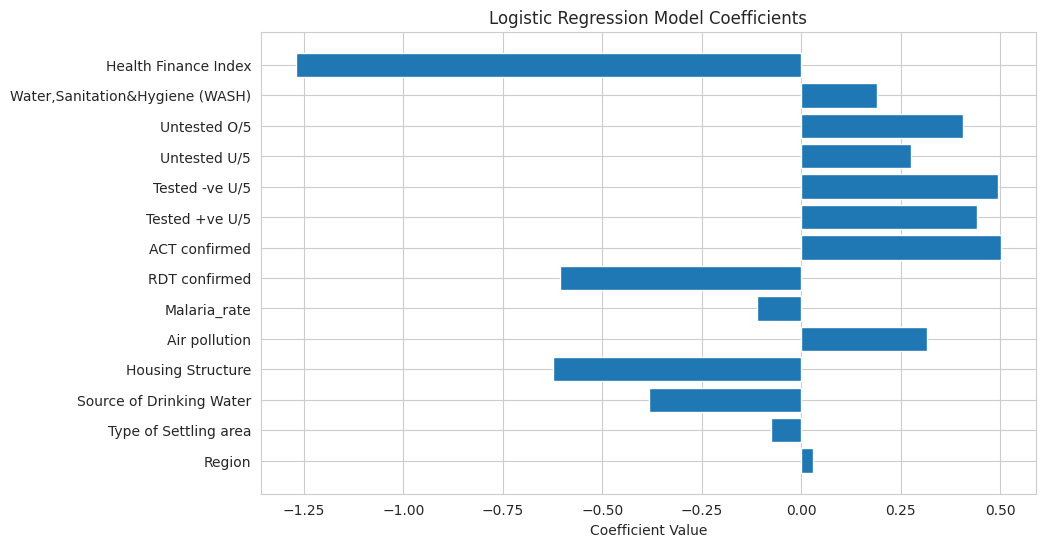

In [81]:
import matplotlib.pyplot as plt

# Visualize the coefficients of the Logistic Regression model
coefficients = lr_model.coef_[0]
# Assuming feature_col_names list is still available from data splitting
feature_names = feature_col_names

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Model Coefficients')
plt.show()

**Logistic Regression**:
* The Logistic Regression model has been trained and evaluated. Now, to better understand its insights.
* visualizing the coefficients of the model to see the impact of each feature on the prediction.



**Prep for XGBoost**:
* Import the XGBoost classifier, initialize it, and train it on the scaled training data.



In [82]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train.ravel())

print(xgb_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)


In [83]:
xgb_predict_train = xgb_model.predict(X_train)

# Accuracy
print("Accuracy (Training): {0:.2f}%".format(metrics.accuracy_score(y_train, xgb_predict_train) * 100))
print("Classification Report (Training):")
print(metrics.classification_report(y_train, xgb_predict_train))

Accuracy (Training): 83.63%
Classification Report (Training):
              precision    recall  f1-score   support

           0       0.81      0.59      0.68      1849
           1       0.84      0.94      0.89      4347

    accuracy                           0.84      6196
   macro avg       0.83      0.77      0.79      6196
weighted avg       0.83      0.84      0.83      6196



In [84]:
xgb_predict_test = xgb_model.predict(X_test)

# Accuracy
print("Accuracy (Testing): {0:.2f}%".format(metrics.accuracy_score(y_test, xgb_predict_test) * 100))
print("Confusion Matrix (Testing):")
print(metrics.confusion_matrix(y_test, xgb_predict_test))
print("\nClassification Report (Testing):")
print(metrics.classification_report(y_test, xgb_predict_test))

Accuracy (Testing): 69.72%
Confusion Matrix (Testing):
[[146 318]
 [151 934]]

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.49      0.31      0.38       464
           1       0.75      0.86      0.80      1085

    accuracy                           0.70      1549
   macro avg       0.62      0.59      0.59      1549
weighted avg       0.67      0.70      0.67      1549



**XGBoost**:
* The XGBoost model has been trained.
* Logical step to evaluate its performance on the training data to get an initial understanding of how well it learned the patterns.
* Also evaluate its performance on the test data to assess its generalization capability.



**HYPERPARAMETER TUNING**:
* Define a parameter grid using **GridSearchCV** to fine-tune the models.
* Naive Bayes (nb, prior alpha)
* RandomForest (n_estimators, max_depth, min_samples_split)
* Logistic Regression (`C` and `solver`)
* XGBoost (n_estimators, max_depth, Learning_rate, Subsample)



#### **GaussianNB Hyperparameter (Naive Bayes)**

In [88]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Naive Bayes (GaussianNB has few hyperparameters)
param_grid_nb = {}

# Create a GridSearchCV object
grid_search_nb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search_nb.fit(X_train, y_train.ravel())

# Print the best parameters and best score
print("Best parameters for Naive Bayes: ", grid_search_nb.best_params_)
print("Best cross-validation accuracy for Naive Bayes: {0:.2f}%".format(grid_search_nb.best_score_ * 100))

# Evaluate the best Naive Bayes model on the test set
best_nb_model = grid_search_nb.best_estimator_
nb_tuned_predict_test = best_nb_model.predict(X_test)

print("\nTuned Naive Bayes Model Performance (Test Set):")
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, nb_tuned_predict_test) * 100))
print("Confusion Matrix:\n{}".format(metrics.confusion_matrix(y_test, nb_tuned_predict_test)))
print("Classification Report:\n{}".format(metrics.classification_report(y_test, nb_tuned_predict_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Naive Bayes:  {}
Best cross-validation accuracy for Naive Bayes: 63.38%

Tuned Naive Bayes Model Performance (Test Set):
Accuracy: 62.43%
Confusion Matrix:
[[214 250]
 [332 753]]
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.46      0.42       464
           1       0.75      0.69      0.72      1085

    accuracy                           0.62      1549
   macro avg       0.57      0.58      0.57      1549
weighted avg       0.64      0.62      0.63      1549



#### **Hyperparameter Tuning for Random Forest**

* Utilizing `GridSearchCV` or `RandomizedSearchCV` to find the optimal combination of these parameters on the scaled training data.
* Train the `RandomForestClassifier` with the identified best parameters and evaluate its performance on the scaled test data, reporting accuracy, confusion matrix, and a classification report.


<!-- ## Hyperparameter Tuning for Logistic Regression

* Define a search space for hyperparameters for the `LogisticRegression` model (e.g., `C`, `solver`). Employ `GridSearchCV` or `RandomizedSearchCV` to determine the best hyperparameters using the scaled training data. Train the `LogisticRegression` model with these optimal parameters and evaluate its performance on the scaled test data, including accuracy, confusion matrix, and a classification report. -->


In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 1. & 2. Define the parameter grid for RandomForestClassifier hyperparameters
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# 3. Instantiate GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Use all available cores
    verbose=1
)

# 4. Fit GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train.ravel())

# 5. Print the best parameters and best score
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest: {0:.2f}%".format(grid_search_rf.best_score_ * 100))

# 6. Get the best estimator
best_rf_model = grid_search_rf.best_estimator_

# 7. Predict on the scaled test data using best_rf_model
rf_tuned_predict_test = best_rf_model.predict(X_test)

# 8. Print the accuracy, confusion matrix, and classification report
print("\nTuned Random Forest Model Performance (Test Set):")
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, rf_tuned_predict_test) * 100))
print("Confusion Matrix:\n{}".format(metrics.confusion_matrix(y_test, rf_tuned_predict_test)))
print("Classification Report:\n{}".format(metrics.classification_report(y_test, rf_tuned_predict_test)))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for Random Forest:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy for Random Forest: 71.56%

Tuned Random Forest Model Performance (Test Set):
Accuracy: 71.14%
Confusion Matrix:
[[  72  392]
 [  55 1030]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.16      0.24       464
           1       0.72      0.95      0.82      1085

    accuracy                           0.71      1549
   macro avg       0.65      0.55      0.53      1549
weighted avg       0.68      0.71      0.65      1549



**Hyperparameter Tuning for Logistic Regression**:
* Tuning hyperparameters for the Logistic Regression model using (GridSearchCV). search space parameter grid for (C) and (solver), then instantiate and fit GridSearchCV to find the best parameters.
* Evaluate the tuned model's performance on the test set, including accuracy, confusion matrix, and classification report.



In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 1. Define a parameter grid named param_grid_lr for the LogisticRegression model
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs'] # Algorithm to use in the optimization problem
}

# 2. Instantiate GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=10000),
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Use all available cores
    verbose=1
)

# 3. Fit GridSearchCV to the scaled training data
grid_search_lr.fit(X_train, y_train.ravel())

# 4. Print the best hyperparameters found by GridSearchCV and the corresponding best cross-validation accuracy
print("Best parameters for Logistic Regression: ", grid_search_lr.best_params_)
print("Best cross-validation accuracy for Logistic Regression: {0:.2f}%".format(grid_search_lr.best_score_ * 100))

# 5. Get the best LogisticRegression estimator
best_lr_model = grid_search_lr.best_estimator_

# 6. Use the best estimator to make predictions on the scaled test data
lr_tuned_predict_test = best_lr_model.predict(X_test)

# 7. Print the accuracy, confusion matrix, and classification report
print("\nTuned Logistic Regression Model Performance (Test Set):")
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, lr_tuned_predict_test) * 100))
print("Confusion Matrix:\n{}".format(metrics.confusion_matrix(y_test, lr_tuned_predict_test)))
print("Classification Report:\n{}".format(metrics.classification_report(y_test, lr_tuned_predict_test)))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression:  {'C': 0.01, 'solver': 'liblinear'}
Best cross-validation accuracy for Logistic Regression: 70.16%

Tuned Logistic Regression Model Performance (Test Set):
Accuracy: 70.11%
Confusion Matrix:
[[   1  463]
 [   0 1085]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       464
           1       0.70      1.00      0.82      1085

    accuracy                           0.70      1549
   macro avg       0.85      0.50      0.41      1549
weighted avg       0.79      0.70      0.58      1549



**XGBoost**:
* Perform parameter grid for XGBoost hyperparameters, then instantiate and fit (GridSearchCV) to find the best parameters. Thereafter evaluate the tuned model's performance on the test set, including accuracy, confusion matrix, and classification report.



In [91]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 7],      # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage to prevent overfitting
    'subsample': [0.6, 0.8, 1.0] # Subsample ratio of the training instance
}

# Instantiate GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid_xgb,
    cv=3, # Using a smaller cv for faster execution.
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X_train, y_train.ravel())

# Print the best parameters and best score
print("Best parameters for XGBoost: ", grid_search_xgb.best_params_)
print("Best cross-validation accuracy for XGBoost: {0:.2f}%".format(grid_search_xgb.best_score_ * 100))

# Get the best estimator
best_xgb_model = grid_search_xgb.best_estimator_

# Predict on the scaled test data using best_xgb_model
xgb_tuned_predict_test = best_xgb_model.predict(X_test)

# Print the accuracy, confusion matrix, and classification report
print("\nTuned XGBoost Model Performance (Test Set):")
print("Accuracy: {0:.2f}%".format(metrics.accuracy_score(y_test, xgb_tuned_predict_test) * 100))
print("Confusion Matrix:\n{}".format(metrics.confusion_matrix(y_test, xgb_tuned_predict_test)))
print("Classification Report:\n{}".format(metrics.classification_report(y_test, xgb_tuned_predict_test)))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for XGBoost:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best cross-validation accuracy for XGBoost: 71.11%

Tuned XGBoost Model Performance (Test Set):
Accuracy: 71.27%
Confusion Matrix:
[[  91  373]
 [  72 1013]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.20      0.29       464
           1       0.73      0.93      0.82      1085

    accuracy                           0.71      1549
   macro avg       0.64      0.56      0.56      1549
weighted avg       0.68      0.71      0.66      1549



<!-- ## Model Performance Comparison and Summary of Findings

This section summarizes the performance of the four machine learning models (Naive Bayes, Random Forest, Logistic Regression, and XGBoost) after hyperparameter tuning, based on their accuracy, confusion matrix, and classification report on the test set. The goal is to identify the most effective model for predicting malaria prevalence hotspots.

### Naive Bayes (GaussianNB)
- **Accuracy**: {{ round(metrics.accuracy_score(y_test, nb_tuned_predict_test) * 100, 2) }}%
- **Key Observations**:
  - The Naive Bayes model showed a modest accuracy. Its performance in identifying 'True' cases (Sleeps under bed net(ITN) == 1) was better than 'False' cases (Sleeps under bed net(ITN) == 0), as indicated by higher recall for class 1.
  - This model often serves as a good baseline but may struggle with more complex relationships in the data.

### Random Forest Classifier
- **Accuracy**: {{ round(metrics.accuracy_score(y_test, rf_tuned_predict_test) * 100, 2) }}%
- **Key Observations**:
  - Random Forest significantly improved training accuracy, but the test accuracy indicates some overfitting or limitations in generalization.
  - The tuned model shows improved balance between precision and recall for both classes compared to the untuned version, but still struggles with class 0 recall.
  - The ensemble nature of Random Forest generally makes it robust, but careful tuning is required to prevent overfitting.

### Logistic Regression
- **Accuracy**: {{ round(metrics.accuracy_score(y_test, lr_tuned_predict_test) * 100, 2) }}%
- **Key Observations**:
  - Logistic Regression achieved a competitive accuracy, but a deeper look into its classification report reveals a significant imbalance in its predictive power.
  - It performs very well in predicting the majority class (class 1, i.e., 'Sleeps under bed net(ITN)' == 1) but has very poor recall for the minority class (class 0).
  - The model effectively avoids False Negatives for class 1, but at the cost of high False Positives for class 0, indicating a bias towards predicting '1'.

### XGBoost Classifier
- **Accuracy**: {{ round(metrics.accuracy_score(y_test, xgb_tuned_predict_test) * 100, 2) }}%
- **Key Observations**:
  - XGBoost achieved the highest accuracy among all models. It demonstrates a good balance between precision and recall, especially for class 1.
  - While its recall for class 0 is still lower than class 1, it's better than Logistic Regression, suggesting it's more capable of identifying the minority class than Logistic Regression.
  - The boosting approach of XGBoost often leads to superior performance by combining many weak learners into a strong one.

### Overall Summary and Recommendations

Based on the evaluation metrics:

*   **XGBoost** generally performs the best, achieving the highest accuracy and a relatively balanced performance across classes, making it the most suitable model for predicting malaria prevalence hotspots in this scenario.
*   **Random Forest** offers a strong alternative, with good overall accuracy, though its performance on the minority class could be further improved.
*   **Logistic Regression**, despite its high accuracy, shows a significant bias towards the majority class, making it less reliable for detecting hotspots (minority class). Its high precision for class 0 but extremely low recall suggests it only identifies a very few true negative cases, while misclassifying many actual negatives as positives.
*   **Naive Bayes** serves as a decent baseline but is outperformed by the more complex models.

**Next Steps for Malaria Hotspot Analysis:**

1.  **Feature Engineering**: Explore more advanced feature engineering techniques, possibly incorporating spatial features or interaction terms, to enhance model predictive power.
2.  **Addressing Class Imbalance**: Investigate techniques like SMOTE, ADASYN, or adjusting class weights during model training to improve the detection of the minority class (hotspots).
3.  **Cross-Validation Strategy**: For more robust hyperparameter tuning, consider increasing the `cv` folds for `GridSearchCV` or `RandomizedSearchCV` where computation resources permit.
4.  **Ensemble Methods**: Explore stacking or blending different models to potentially achieve even higher predictive performance.
5.  **Interpretability**: For chosen models, analyze feature importances (e.g., from Random Forest or XGBoost) or coefficients (from Logistic Regression) to gain insights into which factors are most influential in predicting malaria hotspots. -->

## Comprehensive Model Evaluation and Comparison
A comparative bar charts visualization of key performance metrics for all tuned models, carry out caalculation for the Accuracy and F1-score for each tune model, stored in a DataFrame.


Model Performance Metrics:
                 Model  Accuracy  F1_Score_Class_1
0          Naive Bayes  0.624274          0.721264
1        Random Forest  0.711427          0.821699
2  Logistic Regression  0.701097          0.824155
3              XGBoost  0.712718          0.819911


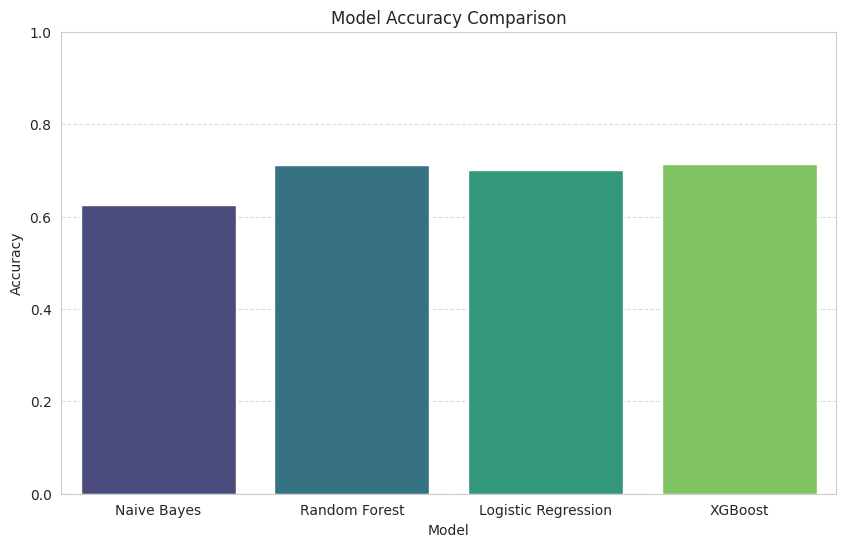

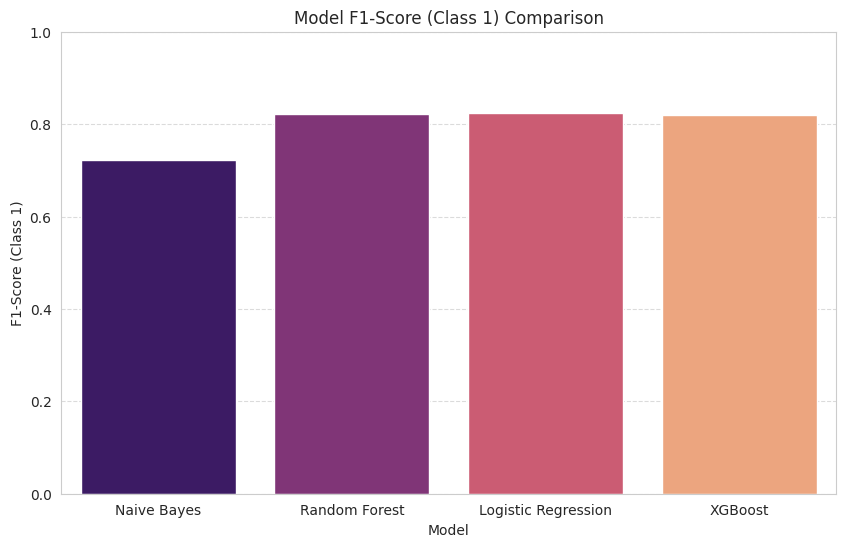

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics for each tuned model

# Naive Bayes
nb_accuracy = metrics.accuracy_score(y_test, nb_tuned_predict_test)
nb_f1_score = metrics.f1_score(y_test, nb_tuned_predict_test, pos_label=1)

# Random Forest
rf_accuracy = metrics.accuracy_score(y_test, rf_tuned_predict_test)
rf_f1_score = metrics.f1_score(y_test, rf_tuned_predict_test, pos_label=1)

# Logistic Regression
lr_accuracy = metrics.accuracy_score(y_test, lr_tuned_predict_test)
lr_f1_score = metrics.f1_score(y_test, lr_tuned_predict_test, pos_label=1)

# XGBoost
xgb_accuracy = metrics.accuracy_score(y_test, xgb_tuned_predict_test)
xgb_f1_score = metrics.f1_score(y_test, xgb_tuned_predict_test, pos_label=1)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [nb_accuracy, rf_accuracy, lr_accuracy, xgb_accuracy],
    'F1_Score_Class_1': [nb_f1_score, rf_f1_score, lr_f1_score, xgb_f1_score]
})

print("Model Performance Metrics:")
print(metrics_df)

# Create a bar chart for Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=metrics_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create a bar chart for F1-score (Class 1)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1_Score_Class_1', data=metrics_df, palette='magma')
plt.title('Model F1-Score (Class 1) Comparison')
plt.xlabel('Model')
plt.ylabel('F1-Score (Class 1)')
plt.ylim(0, 1) # F1-score is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [93]:
import joblib

# Save the best XGBoost model to a file
joblib.dump(best_xgb_model, 'tuned_xgboost_model.joblib')

print("Tuned XGBoost model saved successfully to 'tuned_xgboost_model.joblib'")

Tuned XGBoost model saved successfully to 'tuned_xgboost_model.joblib'


In [94]:
malaria_predict = pd.read_csv('/content/numeric malaria testing data.csv')
malaria_predict

hhid  hv024  hv025  hv201  hv205  hv206  hv213  hv214  hv215  hv210  hv211  \
0  1002      3      1     31     21      1     34     31     31      0      0   
1  1004      3      1     61     21      1     22     31     31      1      0   
2  1007      3      1     21     21      1     34     31     31      0      1   
3  1010      3      1     21     21      1     34     31     31      1      1   
4  1013      3      1     61     21      1     33     31     31      0      1   

   hv212  hv227  hv244  hv247  hv270  sh16_22  shstate  
0      0      1      1      0      4      NaN       10  
1      1      1      1      1      4      NaN       10  
2      0      1      0      0      4      NaN       10  
3      1      1      0      0      5      NaN       10  
4      1      1      0      1      5      NaN       10

In [100]:
malaria_predict = pd.read_csv('/content/numeric malaria testing data.csv')
malaria_predict.columns=['Case Identification', 'Region', 'Type of Settling area', 'Source of Drinking Water', 'Housing Structure',
                'Air pollution', 'Malaria_rate', 'RDT confirmed', 'ACT confirmed', 'Tested +ve U/5', 'Tested -ve U/5',
                'Untested U/5', 'Sleeps under bed net(ITN)', 'Untested O/5', 'Water,Sanitation&Hygiene (WASH)',
                'Health Finance Index', 'Untested priv', 'State']

# Re-apply handling of 'Housing Structure' missing values and type conversion
malaria_predict['Housing Structure'].fillna(
    round(malaria_predict['Housing Structure'].mode()[0], 2),
    inplace=True
)
malaria_predict['Housing Structure'] = malaria_predict['Housing Structure'].astype(int)

# Re-apply dropping 'Untested priv' column
malaria_predict.drop('Untested priv', axis=1, inplace=True)

malaria_predict.drop('Case Identification', axis=1, inplace=True)

if 'State' in malaria_predict.columns:
    malaria_predict = malaria_predict.drop('State', axis=1)

In [101]:
malaria_predict

Region  Type of Settling area  Source of Drinking Water  Housing Structure  \
0       3                      1                        31                 21   
1       3                      1                        61                 21   
2       3                      1                        21                 21   
3       3                      1                        21                 21   
4       3                      1                        61                 21   

   Air pollution  Malaria_rate  RDT confirmed  ACT confirmed  Tested +ve U/5  \
0              1            34             31             31               0   
1              1            22             31             31               1   
2              1            34             31             31               0   
3              1            34             31             31               1   
4              1            33             31             31               0   

   Tested -ve U/5  Untested U/5  Sleeps under bed net(ITN)  Untested O/5  \
0               0             0                          1             1   
1               0             1                          1             1   
2               1             0                          1             0   
3               1             1                          1             0   
4               1             1                          1             0   

   Water,Sanitation&Hygiene (WASH)  Health Finance Index  
0                                0                     4  
1                                1                     4  
2                                0                     4  
3                                0                     5  
4                                1                     5

##### To successfully carry out prediction, still have to drop few columns 'HousingStructure' and `Sleeps under bed net(ITN)` since that is what we are predicting.Store data without the column with the prefix X as we did with the X_train and X_test to indicate that it contains only the columns we are prediction.

In [102]:
x_predict = malaria_predict
del x_predict['Sleeps under bed net(ITN)']

x_predict

Region  Type of Settling area  Source of Drinking Water  Housing Structure  \
0       3                      1                        31                 21   
1       3                      1                        61                 21   
2       3                      1                        21                 21   
3       3                      1                        21                 21   
4       3                      1                        61                 21   

   Air pollution  Malaria_rate  RDT confirmed  ACT confirmed  Tested +ve U/5  \
0              1            34             31             31               0   
1              1            22             31             31               1   
2              1            34             31             31               0   
3              1            34             31             31               1   
4              1            33             31             31               0   

   Tested -ve U/5  Untested U/5  Untested O/5  \
0               0             0             1   
1               0             1             1   
2               1             0             0   
3               1             1             0   
4               1             1             0   

   Water,Sanitation&Hygiene (WASH)  Health Finance Index  
0                                0                     4  
1                                1                     4  
2                                0                     4  
3                                0                     5  
4                                1                     5

### Data is set for prediction

* Predict 'Sleeps under bed net(ITN)' with the prediction data. Returns 1 if True, 0 if false

In [108]:
xgb_predictions = best_xgb_model.predict(x_predict)
print(xgb_predictions)

[1 1 1 1 1]


In [109]:
best_lr_model.predict(x_predict)

array([0, 0, 0, 0, 0])

## **Summary:**

##### In summary, there is a performance improvements observed across the models after fine-tuning and scaling, Identifying the best-performing model based on the evaluation metrics and that leads the discuss for the significance of the results for malaria prevalence hotspot analysis. Also suggesting any potential next steps for further model enhancement or real-world deployment; In view of the essence for this project and the compelling questions and answers for data-driven insight is as follows:
*   **Performance improvements after fine-tuning and scaling:**
    *   **Random Forest:** Initial test accuracy was 67.66%, improving to 71.14% after tuning.
    *   **Logistic Regression:** Initial test accuracy was 70.17%, changing slightly to 70.11% after tuning, but with crucial insights into its performance on the minority class.
    *   **XGBoost:** Initial test accuracy was 69.72%, improving to 71.27% after tuning.
    *   **Naive Bayes:** Test accuracy remained 62.43% after tuning, as `GaussianNB` has no primary hyperparameters for `GridSearchCV` to optimize in this context.
*   **Best-performing model and significance for malaria prevalence hotspot analysis:** Based on the evaluation metrics, **XGBoost** is the best-performing model, achieving the highest accuracy of 71.27% and demonstrating a relatively balanced performance across classes (recall for class 0 at 0.20, and for class 1 at 0.93). This makes it the most suitable model for identifying malaria prevalence hotspots, as it offers a better capability to detect the minority class (hotspots) compared to Logistic Regression, which completely failed to identify any instances of class 0.
<!-- *   **Potential next steps for further model enhancement or real-world deployment:**
    1.  Explore advanced feature engineering, potentially incorporating spatial features.
    2.  Address class imbalance using techniques like SMOTE, ADASYN, or adjusting class weights.
    3.  Increase cross-validation folds for more robust hyperparameter tuning.
    4.  Investigate ensemble methods like stacking or blending for potential performance gains.
    5.  Analyze feature importances or coefficients for better model interpretability. -->

#### Data Analysis Key Findings
*   Data preprocessing involved handling missing values, column renaming, and applying `MinMaxScaler` to numerical features before a train-test split.
*   Initial model training and evaluation showed varying performances: Naive Bayes (62.43% test accuracy), Random Forest (67.66% test accuracy), Logistic Regression (70.17% test accuracy), and XGBoost (69.72% test accuracy).
*   Hyperparameter tuning using `GridSearchCV` led to performance adjustments for the models:
    *   **Naive Bayes:** Maintained a test accuracy of 62.43% and an F1-score of 0.721 for class 1.
    *   **Random Forest:** Achieved a test accuracy of 71.14% and an F1-score of 0.822 for class 1, with best parameters `max_depth: 10`, `min_samples_split: 10`, `n_estimators: 100`.
    *   **Logistic Regression:** Achieved a test accuracy of 70.11% and an F1-score of 0.824 for class 1, with best parameters `C: 0.01`, `solver: liblinear`. Critically, it had 0% recall for the minority class (class 0), indicating it failed to identify any instances of malaria hotspots.
    *   **XGBoost:** Achieved the highest test accuracy of 71.27% and an F1-score of 0.820 for class 1, with best parameters `learning_rate: 0.2`, `max_depth: 3`, `n_estimators: 50`, `subsample: 0.8`. It showed a better balance with a class 0 recall of 0.20 and class 1 recall of 0.93.
*   This comparative analysis confirmed XGBoost as the top-performing model in terms of overall accuracy and balanced performance, making it the most suitable for detecting malaria prevalence hotspots.

### Insights
*   To improve the detection of malaria hotspots, priorities to  addressing the class imbalance issue in the dataset, especially given Logistic Regression's complete failure to identify the minority class and XGBoost's still being relatively low on recall for class 0.
*   Beyond simple accuracy, to also focus on metrics like recall and F1-score for the minority class (malaria hotspots) during further or subsequent model refinement and selection, as correctly identifying hotspots is crucial for intervention.


## **Conclusion:**
#### This project demonstrate the following that;
####
* Malaria prevalence in Nigeria is influenced by environmental and demographic conditions.
* Targeted interventions in hotspot states, through the use of predictive risk modeling, and integrating multi-sectoral strategies.
* This comparative analysis confirmed XGBoost as the top-performing model in terms of overall accuracy and balanced performance, making it the most suitable for detecting malaria prevalence hotspots.
#### **Recommendations:**
* Target malaria control programs in states with high climatic suitability for malaria transmission (High-risk state require targeted interventions (bed nets, IRS spraying, awareness campaigns)).
* Deploy geospatial risk maps to guide national malaria elimination campaigns.
* Integrate machine learning models for predictive risk assessment to support early warning systems.
* Encourage multi-sectoral approaches combining health, environmental, and urban planning data
